In [1]:
import meep as mp
from meep import mpb
import numpy as np
import scipy.ndimage
import math
import matplotlib.pyplot as plt
from itertools import product
import time
#from intersection import *
#from electron_phc import *
import timeit
ħeV = 6.582e-16

In [2]:
def get_material_region(eps):
    material_region = 0.0 * eps
    resolution = eps.shape[0]
    for i in range(resolution):
        for j in range(resolution):
            for k in range(resolution):
                if eps[i,j,k] != 1:
                    material_region[i,j,k] = 1
    return material_region

def get_material_region_1D(eps):
    material_region = 0.0 * eps
    resolution = eps.shape[0]
    for i in range(resolution):
        if eps[i] != 1:
            material_region[i] = 1
    return material_region


# zeros where there is a dielectric, one otherwise
def inv_material_region(eps):
    material_region = 0.0 * eps
    resolution = eps.shape[0]
    for i in range(resolution):
        for j in range(resolution):
            for k in range(resolution):
                if eps[i,j,k] == 1:
                    material_region[i,j,k] = 1
    return material_region
                

In [19]:
def get_mode_info(ms, k_point, pol="none", bloch_phase=False):
    k_points = [k_point]
    efields = []

    #for e field acquisition
    def get_efields(ms, band):
        efields.append(ms.get_efield(band, bloch_phase=bloch_phase))
    ms.k_points = [k_point]
    if pol == "none":
        ms.run(mpb.output_at_kpoint(k_point), mpb.fix_efield_phase,
                  get_efields)
    elif pol == "te":
        print("pol is te")
        ms.run_te(mpb.output_at_kpoint(k_point), mpb.fix_efield_phase,
                  get_efields)
    elif pol == "tm":
        print("pol is tm")
        ms.run_tm(mpb.output_at_kpoint(k_point), mpb.fix_efield_phase,
                  get_efields)
            
#     md = mpb.MPBData(rectify=True, resolution=ms.resolution[0], periods=1)

    converted_Ex = []
    converted_Ey = []
    converted_Ez = [] 
    for f in efields:
        # Get just the x component of the efields
        Ex = f[..., 0]
        Ey = f[..., 1]
        Ez = f[..., 2]
        converted_Ex.append(Ex)
        converted_Ey.append(Ey)
        converted_Ez.append(Ez)

    E = np.array([converted_Ex,converted_Ey, converted_Ez])
    E = np.swapaxes(E, 0, 1)
    omega = ms.all_freqs[0]
    vg = ms.compute_group_velocities()
    vgmags = np.array([np.linalg.norm(v) for v in vg])
    return E, omega, vgmags



def get_mode_info_unfixed(ms, k_point, pol="none", bloch_phase=False):
    k_points = [k_point]
    efields = []

    #for e field acquisition
    def get_efields(ms, band):
        efields.append(ms.get_efield(band, bloch_phase=bloch_phase))
    ms.k_points = [k_point]
    if pol == "none":
        ms.run(mpb.output_at_kpoint(k_point),
                  get_efields)
    elif pol == "te":
        print("pol is te")
        ms.run_te(mpb.output_at_kpoint(k_point),
                  get_efields)
    elif pol == "tm":
        print("pol is tm")
        ms.run_tm(mpb.output_at_kpoint(k_point),
                  get_efields)
            
#     md = mpb.MPBData(rectify=True, resolution=ms.resolution[0], periods=1)

    converted_Ex = []
    converted_Ey = []
    converted_Ez = [] 
    for f in efields:
        # Get just the x component of the efields
        Ex = f[..., 0]
        Ey = f[..., 1]
        Ez = f[..., 2]
        converted_Ex.append(Ex)
        converted_Ey.append(Ey)
        converted_Ez.append(Ez)

    E = np.array([converted_Ex,converted_Ey, converted_Ez])
    E = np.swapaxes(E, 0, 1)
    omega = ms.all_freqs[0]
    vg = ms.compute_group_velocities()
    vgmags = np.array([np.linalg.norm(v) for v in vg])
    return E, omega, vgmags

def get_h_info(ms, k_point):
    hfields = []
    
    def get_hfields(ms, band):
        hfields.append(ms.get_hfield(band, bloch_phase=True))
    
    ms.k_points = [k_point]
    ms.run(mpb.output_at_kpoint(k_point), mpb.fix_hfield_phase,
              get_hfields)
    
    converted_Hx = []
    converted_Hy = []
    converted_Hz = [] 
    for f in hfields:
        # Get just the x component of the efields
        Hx = f[..., 0]
        Hy = f[..., 1]
        Hz = f[..., 2]
        converted_Hx.append(Hx)
        converted_Hy.append(Hy)
        converted_Hz.append(Hz)

    H = np.array([converted_Hx,converted_Hy, converted_Hz])
    H = np.swapaxes(H, 0, 1)
    return H



# N is number of points to keep
# vol is volume of the unit cell, in cartesian (include the jacobian)
def get_M_grid(Ez, material_region, N, vol):
    res = material_region.shape[0]
    ft = np.fft.fftshift(np.fft.fftn(np.multiply(Ez, material_region)))
    # 0 is now at index res/2 = 8
    # res must be even for this to work, and N odd
    lind = res//2 - (N-1)//2 # = 8 - 3 = 5
    uind = res//2 + (N-1)//2 + 1 # 8 + 3 + 1 = 12
    ft_reduce = ft[lind:uind, lind:uind, lind:uind]/(res)**3*vol
    return ft_reduce
    #return ft/(res)**3 #(0,0,0) is stored at (3,3,3) for resolution of 16

def get_M_grid_1D(Ez, material_region, N, vol):
    res = material_region.shape[0]
    ft = np.abs(np.fft.fftshift(np.fft.fftn(np.multiply(Ez, material_region))))
    # 0 is now at index res/2 = 8
    # res must be even for this to work, and N odd
    lind = res//2 - (N-1)//2 # = 8 - 3 = 5
    uind = res//2 + (N-1)//2 + 1 # 8 + 3 + 1 = 12
    ft_reduce = ft[lind:uind]/(res)*vol
    return ft_reduce
    
# same as above but the 0 reciprocal lattice vector is at index [0,0,0]
def get_M_grid_noshift(Ez, material_region, N, vol):
    res = material_region.shape[0]
    ft = np.abs(np.fft.fftn(np.multiply(Ez, material_region)))
    # 0 is now at index res/2 = 8
    # res must be even for this to work, and N odd
    lind = res//2 - (N-1)//2 # = 8 - 3 = 5
    uind = res//2 + (N-1)//2 + 1 # 8 + 3 + 1 = 12
    ft_reduce = ft[lind:uind, lind:uind, lind:uind]/(res)**3*vol
    return ft_reduce
    
# test the fact that the Fourier transform still gives the correct
# answer for a different basis
# put in Ez after rectifying it
# FT = Sum_r Ez*e^(iG.r)
# this is equivalent to fftshift(fftn(multiply(Ez, material_region)))
def fourier_transform(Ez, material_region, N):
    res = material_region.shape[0]
    ft = np.zeros((N,N,N), dtype=complex)
    Ez_reduced = np.multiply(Ez, material_region)
    for x in range(res):
        for y in range(res):
            for z in range(res):
                for ft_i in range(N):
                    for ft_j in range(N):
                        for ft_k in range(N):
                            Gx = ft_i - N//2
                            Gy = ft_j - N//2
                            Gz = ft_k - N//2
                            ft[ft_i, ft_j, ft_k] += Ez_reduced[x,y,z]*np.exp(-2j*np.pi*(x*Gx + y*Gy + z*Gz)/res)
    ft_reduce = np.abs(ft)/(res)**3
    return ft_reduce

# this works
# based on numpy FFT documentation
def oneD_ft(in_arr):
    n = len(in_arr)
    ft = np.zeros(n, dtype=complex)
    for m in range(n):
        for k in range(n):
            ft[k] += in_arr[m] * np.exp(-2j*np.pi *(m*k/n))
    return np.abs(ft)

BCC_basis = 1/2 * np.array([[1,1,-1], [-1,1,1], [1,-1,1]])
sign_options = list(product([-1,0,1],[-1,0,1],[-1,0,1]))
BCC_r_basis = np.array([[1,1,0],[0,1,1],[1,0,1]])
lattice_to_cartesian_BCC = BCC_basis
BCC_to_cartesian_r = np.array([[1,0,1],[1,1,0],[0,1,1]])
BCC_to_cart_r = np.array([[1,0,1],[1,1,0],[0,1,1]])
cart_to_BCC_r = 0.5 * np.array([[1,1,-1],[-1,1,1],[1,-1,1]])

def in_ws_cell_BCC(r):
    r = np.array(r)
    for s in sign_options:
        if s[0] == s[1] and s[1] == s[2] and s[2] == 0:
            continue
        a = np.sum(np.multiply(BCC_basis.T, s).T, axis=0)
        if ((r-0.5*a) @ (a/np.linalg.norm(a)).T) > 0:
            return False
    return True

def in_1BZ_BCC(k):
    k = np.array(k)
    for s in sign_options:
        if s[0] == s[1] and s[1] == s[2] and s[2] == 0:
            continue
        a = np.sum(np.multiply(BCC_r_basis.T, s).T, axis=0)
        if ((k-0.5*a) @ (a/np.linalg.norm(a)).T) > 0:
            return False
    return True

def near_1BZ_BCC(k):
    k = np.array(k)
    for s in sign_options:
        if in_1BZ_BCC(0.15*np.array(s) + k):
            return True
    return False

FCC_to_cartesian_r = np.array([[1, 1, -1],[-1, 1, 1],[1, -1, 1]])
cartesian_to_FCC_r = 1/2 * np.array([[1, 0, 1,], [1, 1, 0], [0, 1, 1]])
FCC_r_basis = np.array([[1, -1, 1], [1, 1, -1], [-1, 1, 1]])
FCC_basis = np.array([[1/2, 0, 1/2], [1/2, 1/2, 0], [0, 1/2, 1/2]])

def in_1BZ_FCC(k):
    k = np.array(k)
    for s in sign_options:
        if s[0] == s[1] and s[1] == s[2] and s[2] == 0:
            continue
        a = np.sum(np.multiply(FCC_r_basis.T, s).T, axis=0)
        if ((k-0.5*a) @ (a/np.linalg.norm(a)).T) > 0:
            return False
    return True

def near_1BZ_FCC(k):
    k = np.array(k)
    for s in sign_options:
        if in_1BZ_FCC(0.15*np.array(s) + k):
            return True
    return False


## 1D

In [ ]:
geometry_lattice = mp.Lattice(size=mp.Vector3(1))
resolution = 512

kmin = mp.Vector3(-0.5)
kmax = mp.Vector3(0.5)

k_points_ni = [kmin, kmax]
k_points = mp.interpolate(11, k_points_ni)

#add a material cube to center
ϵ_ga = 12
ϵ_ln = 5.3
# homogeneous medium
# geometry = [mp.Block(size=mp.Vector3(1.0, mp.inf, mp.inf), center=mp.Vector3(0), material=mp.Medium(epsilon=ϵ_ln))]
# geometry = []
geometry = [mp.Block(size=mp.Vector3(0.99, mp.inf, mp.inf), center=mp.Vector3(-0.01), material=mp.Medium(epsilon=13/2))]
num_bands = 6
                      
ms = mpb.ModeSolver(
    geometry=geometry,
    default_material=mp.Medium(epsilon=1),
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands
)

# ms.run_te()
# eps = np.array(ms.get_epsilon(), dtype=complex)
# material_region = get_material_region_1D(eps)
# te_freqs = ms.all_freqs
# ms.run_tm()
# tm_freqs = ms.all_freqs

ms.run()
all_freqs = ms.all_freqs

eps = np.array(ms.get_epsilon(), dtype=complex)
material_region = get_material_region_1D(eps)

In [ ]:
plt.plot(np.abs(eps))

In [ ]:
plt.plot(all_freqs)

plt.plot(material_region)

In [ ]:
kx =-0.448294
ky = 0.179363
kz = 0
E_1, omega_1, vg = get_mode_info(ms, mp.Vector3(kx, ky, kz), pol="te", bloch_phase=False)
E_1b, omega_1, vg = get_mode_info(ms, mp.Vector3(kx, ky, kz), pol="te", bloch_phase=True)
# E_1u, omega_1, vg = get_mode_info(ms, mp.Vector3(kx, ky, kz), pol="tm", bloch_phase=False)

E_2, omega_2, vg = get_mode_info(ms, mp.Vector3(kx, ky, kz), pol="tm")

In [ ]:
E_1.shape

In [ ]:
plt.plot(np.real(E_1[0,0,:,0,0]))

In [ ]:
b = 0
M_1_x = get_M_grid_1D(E_1[b, 0, :, 0, 0], material_region, 7, 1)
M_1_y = get_M_grid_1D(E_1[b, 1, :, 0, 0], material_region, 7, 1)
M_1_z = get_M_grid_1D(E_1[b, 2, :, 0, 0], material_region, 7, 1)

In [ ]:
np.savez("phc_an_files/phc1d_modes_k0x--0.448294_k0par-0.179363_b-1_te.npz", E_1, E_1b)

In [ ]:
2/13

In [ ]:
np.savez("phc_an_files/phc1d_modes_i_13_tm.npz", E_1)

In [ ]:
b = 1
M_1_x = get_M_grid_1D(E_1[b, 0, :, 0, 0], material_region, 7, 1)
M_1_y = get_M_grid_1D(E_1[b, 1, :, 0, 0], material_region, 7, 1)
M_1_z3 = get_M_grid_1D(E_1[b, 2, :, 0, 0], material_region, 7, 1)
M_2_x = get_M_grid_1D(E_1b[b, 0, :, 0, 0], material_region, 7, 1)
M_2_y = get_M_grid_1D(E_1b[b, 1, :, 0, 0], material_region, 7, 1)
M_2_z = get_M_grid_1D(E_1b[b, 2, :, 0, 0], material_region, 7, 1)

In [ ]:
M_1_y_ft = np.fft.fftshift(oneD_ft(np.multiply(E_1[b, 1, :, 0, 0], material_region)))/resolution

In [ ]:
np.savez("phc_an_files/phc1d_M_1_z_kpar-0.3_tm.npz", M_1_z)

In [ ]:
num_sample = 25
BZ_sample = np.linspace(-0.5,0.5, num_sample)
print(BZ_sample)
num_bands = 6
# number of points in mode integral to keep (which is in Fourier space, remember)
N_offset = 7

Mx_vals_te = np.zeros([num_bands, num_sample, num_sample, N_offset])
Mpar_vals_te = np.zeros([num_bands, num_sample, num_sample, N_offset])
omega_vals_te = np.zeros([num_bands, num_sample, num_sample])
vg_vals_te = np.zeros([num_bands, num_sample, num_sample])

Mx_vals_tm = np.zeros([num_bands, num_sample, num_sample, N_offset])
Mpar_vals_tm = np.zeros([num_bands, num_sample, num_sample, N_offset])
omega_vals_tm = np.zeros([num_bands, num_sample, num_sample])
vg_vals_tm = np.zeros([num_bands, num_sample, num_sample])



for (l, kx) in enumerate(BZ_sample):
    for (m, kpar) in enumerate(BZ_sample*8):
        k = mp.Vector3(kx, kpar, 0)
        E, omega, vgmag = get_mode_info(ms, k, pol="te")
        for i in range(num_bands):
            Ex = np.array(E[i,0,:,0,0])
            Epar = np.array(E[i,1,:,0,0])
            Mx = get_M_grid_1D(Ex, material_region, N_offset,1)
            Mpar = get_M_grid_1D(Epar, material_region, N_offset,1)
            Mx_vals_te[i,l,m,:] = Mx
            Mpar_vals_te[i,l,m,:] = Mpar
        omega_vals_te[:,l,m] = omega
        vg_vals_te[:,l,m] = vgmag
        E, omega, vgmag = get_mode_info(ms, k, pol="tm")
        for i in range(num_bands):
            Ex = np.array(E[i,0,:,0,0])
            Epar = np.array(E[i,2,:,0,0])
            Mx = get_M_grid_1D(Ex, material_region, N_offset,1)
            Mpar = get_M_grid_1D(Epar, material_region, N_offset,1)
            Mx_vals_tm[i,l,m,:] = Mx
            Mpar_vals_tm[i,l,m,:] = Mpar
        omega_vals_tm[:,l,m] = omega
        vg_vals_tm[:,l,m] = vgmag
#             if kz == 0:
#                 E, omega, vgmag = get_mode_info(ms, k)
#             else:
#                 E, omega, vgmag = get_mode_info(ms, k, pol="tm")
#             Mbands = []
#             for i in range(num_bands):
#                 Ex = np.array(E[i,0,:,0,0])
#                 Ey = np.array(E[i,1,:,0,0])
#                 Ez = np.array(E[i,2,:,0,0])
#                 Mx = get_M_grid_1D(Ex, material_region, N_offset,1)
#                 My = get_M_grid_1D(Ey, material_region, N_offset,1)
#                 Mz = get_M_grid_1D(Ez, material_region, N_offset,1)
#                 Mx_vals_tm[i,l,m,n,:] = Mx
#                 My_vals_tm[i,l,m,n,:] = My
#                 Mz_vals_tm[i,l,m,n,:] = Mz
#             omega_vals_tm[:,l,m,n] = omega
#             vg_vals_tm[:,l,m,n] = vgmag

In [ ]:
np.savez("phc_an_files/phc1d_fs_ish_largek_kpar_te_ga_2.npz", BZ_sample, Mx_vals_te, Mpar_vals_te, omega_vals_te, vg_vals_te)
np.savez("phc_an_files/phc1d_fs_ish_largek_kpar_tm_ga_2.npz", BZ_sample, Mx_vals_tm, Mpar_vals_tm, omega_vals_tm, vg_vals_tm)

In [ ]:
as_arr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for a in as_arr:
    print("a = " + str(a))
    ms.geometry = [mp.Block(size=mp.Vector3(a, mp.inf, mp.inf), center=mp.Vector3(-0.5 + a/2), material=mp.Medium(epsilon=13))]
    ms.run()
    eps = np.array(ms.get_epsilon(), dtype=complex)
    material_region = get_material_region_1D(eps)
    
    num_sample = 25
    BZ_sample = np.linspace(-0.5,0.5, num_sample)
    print(BZ_sample)
    num_bands = 6
    # number of points in mode integral to keep (which is in Fourier space, remember)
    N_offset = 7

    Mx_vals_te = np.zeros([num_bands, num_sample, num_sample, N_offset])
    Mpar_vals_te = np.zeros([num_bands, num_sample, num_sample, N_offset])
    omega_vals_te = np.zeros([num_bands, num_sample, num_sample])
    vg_vals_te = np.zeros([num_bands, num_sample, num_sample])

    Mx_vals_tm = np.zeros([num_bands, num_sample, num_sample, N_offset])
    Mpar_vals_tm = np.zeros([num_bands, num_sample, num_sample, N_offset])
    omega_vals_tm = np.zeros([num_bands, num_sample, num_sample])
    vg_vals_tm = np.zeros([num_bands, num_sample, num_sample])



    for (l, kx) in enumerate(BZ_sample):
        for (m, kpar) in enumerate(BZ_sample*8):
            k = mp.Vector3(kx, kpar, 0)
            E, omega, vgmag = get_mode_info(ms, k, pol="te")
            for i in range(num_bands):
                Ex = np.array(E[i,0,:,0,0])
                Epar = np.array(E[i,1,:,0,0])
                Mx = get_M_grid_1D(Ex, material_region, N_offset,1)
                Mpar = get_M_grid_1D(Epar, material_region, N_offset,1)
                Mx_vals_te[i,l,m,:] = Mx
                Mpar_vals_te[i,l,m,:] = Mpar
            omega_vals_te[:,l,m] = omega
            vg_vals_te[:,l,m] = vgmag
            E, omega, vgmag = get_mode_info(ms, k, pol="tm")
            for i in range(num_bands):
                Ex = np.array(E[i,0,:,0,0])
                Epar = np.array(E[i,2,:,0,0])
                Mx = get_M_grid_1D(Ex, material_region, N_offset,1)
                Mpar = get_M_grid_1D(Epar, material_region, N_offset,1)
                Mx_vals_tm[i,l,m,:] = Mx
                Mpar_vals_tm[i,l,m,:] = Mpar
            omega_vals_tm[:,l,m] = omega
            vg_vals_tm[:,l,m] = vgmag
            
    np.savez("phc_an_files/phc1d_kpar_te_ga_a_" + str(a) + ".npz", BZ_sample, Mx_vals_te, Mpar_vals_te, omega_vals_te, vg_vals_te)
    np.savez("phc_an_files/phc1d_kpar_tm_ga_a_" + str(a) + ".npz", BZ_sample, Mx_vals_tm, Mpar_vals_tm, omega_vals_tm, vg_vals_tm)

eps = np.array(ms.get_epsilon(), dtype=complex)
material_region = get_material_region_1D(eps)

## SC

In [5]:
#messing around with 3D now
geometry_lattice = mp.Lattice(size=mp.Vector3(1,1,1))
resolution = 16

Gamma = mp.Vector3(0,0,0)
X = mp.Vector3(0.5,0,0)
M = mp.Vector3(0.5,0.5,0)
K = mp.Vector3(0.3,0.4,0.5)

k_points = [M, X, Gamma, K, M, Gamma]
# k_points = [M, Gamma, X, M]
k_points = mp.interpolate(8, k_points)

#add a material cube to center
# geometry = [mp.Block(center=mp.Vector3(0.1, 0.1, 0.1), material=mp.Medium(epsilon=1.0), size=mp.Vector3(0.1, 0.1, 0.1))]
# geometry = [mp.Block(center=mp.Vector3(0.5, 0.5, 0.5), material=mp.Medium(epsilon=12.0), size=mp.Vector3(1,1,1))]
#geometry = [mp.Block(center=mp.Vector3(0,0,0), material=mp.Medium(epsilon=10.0), size=mp.Vector3(0.2, 0.2, 0.2))]
rsphere = 0.25
geometry = [mp.Sphere(rsphere, center=mp.Vector3(0,0,0), material=mp.Medium(epsilon=12.0))]
num_bands = 12
                      
ms = mpb.ModeSolver(
    geometry=geometry,
    default_material=mp.Medium(epsilon=1.0),
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands,
    dimensions=3
)

ms.run()
eps = np.array(ms.get_epsilon(), dtype=complex)
material_region = get_material_region(eps)
all_freqs = ms.all_freqs


# ms.run_tm()
# tm_freqs = ms.all_freqs

# ms.run()
# all_freqs = ms.all_freqs

# ms.run_tm()
# eps = np.array(ms.get_epsilon(), dtype=complex)
# material_region = get_material_region(eps)
# imaterial_region = inv_material_region(eps)

Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     sphere, center = (0,0,0)
          radius 0.25
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
46 k-points
  Vector3<0.5, 0.5, 0.0>
  Vector3<0.5, 0.4444444444444444, 0.0>
  Vector3<0.5, 0.3888888888888889, 0.0>
  Vector3<0.5, 0.33333333333333337, 0.0>
  Vector3<0.5, 0.2777777777777778, 0.0>
  Vector3<0.5, 0.2222222222222222, 0.0>
  Vector3<0.5, 0.16666666666666669, 0.0>
  Vector3<0.5, 0.11111111111111116, 0.0>
  Vector3<0.5, 0.05555555555555558, 0.0>
  Vect

    linmin: converged after 2 iterations.
    iteration   30: trace = 3.319084779074218 (0.001227% change)
    linmin: converged after 2 iterations.
    iteration   31: trace = 3.319058136225279 (0.00080272% change)
    linmin: converged after 2 iterations.
    iteration   32: trace = 3.319040640362284 (0.000527135% change)
    linmin: converged after 2 iterations.
    iteration   33: trace = 3.319030034151441 (0.000319557% change)
    linmin: converged after 2 iterations.
    iteration   34: trace = 3.319024197878798 (0.000175843% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   35: trace = 3.319021031909204 (9.53886e-05% change)
    iteration   36: trace = 3.319018959962646 (6.24265e-05% change)
    iteration   37: trace = 3.319017412297157 (4.66302e-05% change)
    iteration   38: trace = 3.319016516029349 (2.7004e-05% change)
    iteration   39: trace = 3.319016038278783 (1.43943e-05% change)
  

Solving for bands 1 to 6...
    linmin: converged after 3 iterations.
    iteration    1: trace = 1.769878559971854 (0.698358% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 1.766736113483463 (0.177709% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 1.76601601319078 (0.0407671% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 1.765824641588579 (0.0108369% change)
    linmin: converged after 3 iterations.
    iteration    5: trace = 1.7657772187824 (0.00268563% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 1.765763447149614 (0.000779922% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 1.765759445142073 (0.000226645% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    8: trace = 1.765758886755568 (3.1623e-05% change)
    iteration    9: trace = 1.765758

    linmin: converged after 4 iterations.
    iteration    2: trace = 3.467209165965392 (0.193652% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 3.463682302376756 (0.101772% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 3.462203178609391 (0.0427129% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 3.461904513818634 (0.00862681% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 3.461731794901579 (0.00498925% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 3.461675954047226 (0.0016131% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 3.461642973443962 (0.00095274% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 3.461623489690932 (0.000562849% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   10: 

    linmin: converged after 3 iterations.
    iteration   80: trace = 3.450598504600224 (0.0308716% change)
    linmin: converged after 3 iterations.
    iteration   81: trace = 3.45009355634196 (0.0146347% change)
    linmin: converged after 3 iterations.
    iteration   82: trace = 3.449917684312565 (0.00509773% change)
    linmin: converged after 2 iterations.
    iteration   83: trace = 3.449831717019979 (0.0024919% change)
    linmin: converged after 2 iterations.
    iteration   84: trace = 3.449783596385394 (0.00139488% change)
    linmin: converged after 2 iterations.
    iteration   85: trace = 3.449763010456316 (0.000596733% change)
    linmin: converged after 2 iterations.
    iteration   86: trace = 3.449748542021385 (0.000419405% change)
    linmin: converged after 3 iterations.
    iteration   87: trace = 3.44974027177565 (0.000239735% change)
    linmin: converged after 2 iterations.
    iteration   88: trace = 3.449736605864861 (0.000106266% change)
    linmin: converge

    linmin: converged after 2 iterations.
    iteration   10: trace = 3.441052231877609 (0.000572493% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 3.441037453045193 (0.000429487% change)
    linmin: converged after 3 iterations.
    iteration   12: trace = 3.441026013291518 (0.000332451% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   13: trace = 3.441014893046123 (0.000323167% change)
    iteration   14: trace = 3.440997767507976 (0.00049769% change)
    iteration   15: trace = 3.440978448689513 (0.000561432% change)
    switching back to exact line minimization
    iteration   16: trace = 3.440957950955061 (0.000595697% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 3.440948921264439 (0.000262418% change)
    linmin: converged after 2 iterations.
    iteration   18: trace = 3.440946022515198 (8.42428e-05% change)
    linmin: converge

    switching to approximate line minimization (decrease time by 100%)
    iteration   17: trace = 3.436677533228483 (2.00007e-05% change)
    iteration   18: trace = 3.436676881054035 (1.89769e-05% change)
    iteration   19: trace = 3.436676512354155 (1.07284e-05% change)
    iteration   20: trace = 3.436676415909094 (2.80635e-06% change)
Finished solving for bands 7 to 12 after 20 iterations.
Finished k-point with 15 mean iterations/band.
freqs:, 10, 0.5, 0, 0, 0.5, 0.431845, 0.431856, 0.457852, 0.457856, 0.577051, 0.633177, 0.633183, 0.743518, 0.771455, 0.77148, 0.801353, 0.806503
elapsed time for k point: 0.36316370964050293
solve_kpoint (0.444444,0,0):
Solving for bands 1 to 6...
    linmin: converged after 4 iterations.
    iteration    1: trace = 1.531699897314648 (0.456541% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 1.529675572846441 (0.132249% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 1.529205505874116 (0.

    switching back to exact line minimization
    iteration    9: trace = 3.49066646865972 (0.000979101% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 3.490657595504975 (0.000254197% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   11: trace = 3.490654950859017 (7.57636e-05% change)
    iteration   12: trace = 3.490654189313714 (2.18167e-05% change)
    iteration   13: trace = 3.490654012356555 (5.06946e-06% change)
Finished solving for bands 7 to 12 after 13 iterations.
Finished k-point with 11.5 mean iterations/band.
freqs:, 13, 0.333333, 0, 0, 0.333333, 0.304566, 0.304571, 0.541549, 0.54156, 0.575911, 0.662287, 0.662297, 0.739943, 0.777807, 0.777837, 0.800402, 0.808606
elapsed time for k point: 0.28054118156433105
solve_kpoint (0.277778,0,0):
Solving for bands 1 to 6...
    linmin: converged after 3 iterations.
    iteration    1: trace = 1.550632478782078 (0.56682

    switching to approximate line minimization (decrease time by 100%)
    iteration   10: trace = 1.535069050819252 (0.000193293% change)
    iteration   11: trace = 1.535068161826898 (5.79122e-05% change)
    iteration   12: trace = 1.535067861737535 (1.95489e-05% change)
    iteration   13: trace = 1.535067785663154 (4.95577e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    iteration    1: trace = 3.618056258489669 (0.282666% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 3.612251969065317 (0.160554% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 3.609325910916078 (0.0810365% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 3.607648797428434 (0.0464769% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 3.607090514816822 (0.0154762% change)
    linmin: converged after 4 itera

    linmin: converged after 2 iterations.
    iteration    4: trace = 2.579036261251829 (0.00600131% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 2.579012419990472 (0.000924429% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 2.579007206588891 (0.000202147% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 2.579004881753593 (9.01446e-05% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.579003563094723 (5.11305e-05% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 2.579002480524066 (4.19763e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 2.5790020187905 (1.79036e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 2.579001869257774 (5.79809e-06% change)
Finished solving for bands 3 to 8 after 11 iterations.
Solving for bands 9 to 12...
    linmin: converged after 4 iteration

    switching back to exact line minimization
    iteration   13: trace = 3.632987556308847 (6.61906e-06% change)
Finished solving for bands 7 to 12 after 13 iterations.
Finished k-point with 30.5 mean iterations/band.
freqs:, 20, 0.0333333, 0.0444444, 0.0555556, 0.0785674, 0.0727582, 0.0727613, 0.57178, 0.572197, 0.572495, 0.726026, 0.728339, 0.729568, 0.796699, 0.796765, 0.797879, 0.814902
elapsed time for k point: 0.6565279960632324
solve_kpoint (0.0666667,0.0888889,0.111111):
Solving for bands 1 to 6...
    linmin: converged after 4 iterations.
    iteration    1: trace = 1.539054844218513 (0.639574% change)
    linmin: converged after 3 iterations.
    iteration    2: trace = 1.534786369982297 (0.277729% change)
    linmin: converged after 3 iterations.
    iteration    3: trace = 1.534116269782194 (0.0436703% change)
    linmin: converged after 3 iterations.
    iteration    4: trace = 1.533854784100838 (0.0170462% change)
    linmin: converged after 2 iterations.
    iteration  

    iteration   20: trace = 3.579527439711998 (0.000121057% change)
    linmin: converged after 2 iterations.
    iteration   21: trace = 3.579523671840109 (0.000105262% change)
    linmin: converged after 2 iterations.
    iteration   22: trace = 3.579520386037356 (9.17945e-05% change)
    linmin: converged after 2 iterations.
    iteration   23: trace = 3.579517590733806 (7.80916e-05% change)
    linmin: converged after 2 iterations.
    iteration   24: trace = 3.579515146532508 (6.8283e-05% change)
    linmin: converged after 2 iterations.
    iteration   25: trace = 3.579513177128494 (5.50188e-05% change)
    linmin: converged after 2 iterations.
    iteration   26: trace = 3.579511474128511 (4.75763e-05% change)
    linmin: converged after 2 iterations.
    iteration   27: trace = 3.579510155657113 (3.68338e-05% change)
    linmin: converged after 2 iterations.
    iteration   28: trace = 3.579509091876205 (2.97186e-05% change)
    linmin: converged after 2 iterations.
    iterati

freqs:, 24, 0.166667, 0.222222, 0.277778, 0.392837, 0.357036, 0.357744, 0.556816, 0.566104, 0.573183, 0.668194, 0.695224, 0.731732, 0.785094, 0.791854, 0.801355, 0.805475
elapsed time for k point: 0.6724944114685059
solve_kpoint (0.2,0.266667,0.333333):
Solving for bands 1 to 6...
    linmin: converged after 3 iterations.
    iteration    1: trace = 1.744095718111924 (0.533491% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 1.741433759442835 (0.152743% change)
    linmin: converged after 3 iterations.
    iteration    3: trace = 1.740935266757023 (0.0286295% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 1.740724069130485 (0.012132% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    5: trace = 1.74067013917879 (0.00309818% change)
    iteration    6: trace = 1.74065367756425 (0.00094571% change)
    iteration    7: trace = 1.74064314412419

    iteration    9: trace = 3.509064312611186 (0.00794415% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 3.50881550110242 (0.00709079% change)
    linmin: converged after 4 iterations.
    iteration   11: trace = 3.508614575574359 (0.00572647% change)
    linmin: converged after 4 iterations.
    iteration   12: trace = 3.508451094791658 (0.00465952% change)
    linmin: converged after 4 iterations.
    iteration   13: trace = 3.50833514352341 (0.00330497% change)
    linmin: converged after 4 iterations.
    iteration   14: trace = 3.508212760864388 (0.0034884% change)
    linmin: converged after 4 iterations.
    iteration   15: trace = 3.50812636874704 (0.0024626% change)
    linmin: converged after 4 iterations.
    iteration   16: trace = 3.508049686873164 (0.00218586% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 3.507986377245521 (0.00180471% change)
    linmin: converged after 4 iterations.
    iteration   18: trac

    linmin: converged after 2 iterations.
    iteration   28: trace = 3.495702326429101 (0.000426239% change)
    linmin: converged after 2 iterations.
    iteration   29: trace = 3.495692704687972 (0.000275245% change)
    linmin: converged after 2 iterations.
    iteration   30: trace = 3.495687670220717 (0.000144019% change)
    linmin: converged after 2 iterations.
    iteration   31: trace = 3.495685124322089 (7.28297e-05% change)
    linmin: converged after 2 iterations.
    iteration   32: trace = 3.495683684992903 (4.11745e-05% change)
    linmin: converged after 2 iterations.
    iteration   33: trace = 3.495682710986274 (2.78631e-05% change)
    linmin: converged after 2 iterations.
    iteration   34: trace = 3.495681944090662 (2.19384e-05% change)
    linmin: converged after 2 iterations.
    iteration   35: trace = 3.495681328746477 (1.7603e-05% change)
    linmin: converged after 2 iterations.
    iteration   36: trace = 3.495680805031651 (1.49818e-05% change)
    linmin:

Finished solving for bands 1 to 6 after 11 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    iteration    1: trace = 3.553179244842175 (0.325843% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 3.545444441070228 (0.217924% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 3.542909393023161 (0.0715271% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 3.541575423887636 (0.0376589% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 3.540925440032149 (0.0183546% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 3.540288403874327 (0.0179923% change)
    iteration    7: trace = 3.539982072152905 (0.00865311% change)
    iteration    8: trace = 3.539730608636889 (0.00710378% change)
    iteration    9: trace = 3.539525437487853 (0.0057964% change)

    iteration   22: trace = 3.556563291501244 (0.00301321% change)
    linmin: converged after 4 iterations.
    iteration   23: trace = 3.556426754893244 (0.00383908% change)
    linmin: converged after 4 iterations.
    iteration   24: trace = 3.556258487870182 (0.00473146% change)
    linmin: converged after 3 iterations.
    iteration   25: trace = 3.556111977177713 (0.00411988% change)
    linmin: converged after 3 iterations.
    iteration   26: trace = 3.556001234989982 (0.00311419% change)
    linmin: converged after 3 iterations.
    iteration   27: trace = 3.555924804776333 (0.00214935% change)
    linmin: converged after 3 iterations.
    iteration   28: trace = 3.555852202933573 (0.00204174% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   29: trace = 3.555791608209766 (0.0017041% change)
    iteration   30: trace = 3.555752001166453 (0.00111388% change)
    iteration   31: trace = 3.555

    linmin: converged after 4 iterations.
    iteration    3: trace = 1.977648290864114 (0.0322398% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 1.977320029661308 (0.0165999% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 1.977191637973145 (0.00649343% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 1.977122114612745 (0.00351633% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 1.977095423471061 (0.00135001% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 1.977083159512778 (0.000620304% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 1.977077278067465 (0.000297481% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 1.977075864795117 (7.14829e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 1.977075273431625 (2.9911e-05% change)
    linmin: conver

    linmin: converged after 2 iterations.
    iteration   23: trace = 3.452165780820111 (7.46633e-05% change)
    linmin: converged after 2 iterations.
    iteration   24: trace = 3.452163451149286 (6.74843e-05% change)
    linmin: converged after 2 iterations.
    iteration   25: trace = 3.452161599715727 (5.36311e-05% change)
    linmin: converged after 2 iterations.
    iteration   26: trace = 3.452160107394631 (4.32286e-05% change)
    linmin: converged after 2 iterations.
    iteration   27: trace = 3.452159130124379 (2.8309e-05% change)
    linmin: converged after 2 iterations.
    iteration   28: trace = 3.452158435800313 (2.01128e-05% change)
    linmin: converged after 2 iterations.
    iteration   29: trace = 3.452157931864463 (1.45977e-05% change)
    linmin: converged after 2 iterations.
    iteration   30: trace = 3.452157598134087 (9.6673e-06% change)
Finished solving for bands 7 to 12 after 30 iterations.
Finished k-point with 21 mean iterations/band.
freqs:, 33, 0.41111

    linmin: converged after 4 iterations.
    iteration   12: trace = 3.368956321125196 (0.00502524% change)
    linmin: converged after 4 iterations.
    iteration   13: trace = 3.368845680621375 (0.00328417% change)
    linmin: converged after 4 iterations.
    iteration   14: trace = 3.368707805940331 (0.00409272% change)
    linmin: converged after 4 iterations.
    iteration   15: trace = 3.368596967194636 (0.0032903% change)
    linmin: converged after 4 iterations.
    iteration   16: trace = 3.368496501100779 (0.00298248% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 3.368436425095377 (0.00178348% change)
    linmin: converged after 2 iterations.
    iteration   18: trace = 3.368400609503673 (0.00106328% change)
    linmin: converged after 2 iterations.
    iteration   19: trace = 3.368379685189423 (0.000621196% change)
    linmin: converged after 2 iterations.
    iteration   20: trace = 3.3683679222138 (0.000349218% change)
    linmin: converge

    linmin: converged after 4 iterations.
    iteration    4: trace = 3.32012724563974 (0.0219484% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 3.319726216468444 (0.0120795% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 3.31948878498794 (0.0071524% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 3.319338965030457 (0.00451345% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 3.319230242980872 (0.00327547% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 3.31914610321351 (0.00253495% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 3.319093688838192 (0.00157916% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 3.319053031368704 (0.00122496% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 3.319031470852662 (0.000649601% change)
    linmin: converged af

    iteration   12: trace = 3.414202564810945 (0.00119187% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 3.414189883424389 (0.000371431% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 3.414183687878808 (0.000181465% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 3.414180465123862 (9.43932e-05% change)
    linmin: converged after 2 iterations.
    iteration   16: trace = 3.41417846000622 (5.87291e-05% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 3.414177397792022 (3.11119e-05% change)
    linmin: converged after 2 iterations.
    iteration   18: trace = 3.41417685334494 (1.59467e-05% change)
    linmin: converged after 2 iterations.
    iteration   19: trace = 3.414176576158267 (8.1187e-06% change)
Finished solving for bands 7 to 12 after 19 iterations.
Finished k-point with 14 mean iterations/band.
freqs:, 39, 0.388889, 0.388889, 0, 0.549972, 0.478259, 0.482644

    iteration   21: trace = 3.532481291091677 (0.000115452% change)
    linmin: converged after 2 iterations.
    iteration   22: trace = 3.532478518781251 (7.84806e-05% change)
    linmin: converged after 2 iterations.
    iteration   23: trace = 3.532476289559673 (6.31065e-05% change)
    linmin: converged after 2 iterations.
    iteration   24: trace = 3.532474270911093 (5.71454e-05% change)
    linmin: converged after 2 iterations.
    iteration   25: trace = 3.532473089377873 (3.34478e-05% change)
    linmin: converged after 2 iterations.
    iteration   26: trace = 3.532472436895508 (1.8471e-05% change)
    linmin: converged after 2 iterations.
    iteration   27: trace = 3.532472036293717 (1.13406e-05% change)
    linmin: converged after 2 iterations.
    iteration   28: trace = 3.532471759989109 (7.82185e-06% change)
Finished solving for bands 7 to 12 after 28 iterations.
Finished k-point with 19 mean iterations/band.
freqs:, 41, 0.277778, 0.277778, 0, 0.392837, 0.356283, 0.358

    iteration    2: trace = 1.538632035058767 (0.33532% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 1.537477544018014 (0.0750618% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    4: trace = 1.536958643352825 (0.0337558% change)
    iteration    5: trace = 1.536836272752341 (0.00796218% change)
    switching back to exact line minimization
    iteration    6: trace = 1.536759966108014 (0.0049653% change)
    linmin: converged after 3 iterations.
    iteration    7: trace = 1.536722581587264 (0.00243271% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 1.536702629168088 (0.00129838% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 1.536693732627076 (0.000578939% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 1.536690717588252 (0.000196203% change)
    linmin: converged after 2 it

    linmin: converged after 2 iterations.
    iteration    8: trace = 2.579107862582148 (0.00449649% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 2.579023451093628 (0.00327295% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 2.579007330519913 (0.000625067% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 2.579003281657738 (0.000156993% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 2.579002104064272 (4.56608e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 2.579001872049147 (8.99631e-06% change)
Finished solving for bands 3 to 8 after 13 iterations.
Solving for bands 9 to 12...
    linmin: converged after 5 iterations.
    iteration    1: trace = 2.602593232133917 (10.4775% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 2.582700487228261 (0.767276% change)
    linmin: converged after 4 iterations.
   

In [ ]:
eps = np.array(ms.get_epsilon(), dtype=complex)

In [ ]:
# plt.plot(tm_freqs  * 2*np.pi*3e8/(0.5e-6)*6.6e-16, 'r')
# plt.plot(te_freqs  * 2*np.pi*3e8/(0.5e-6)*6.6e-16, 'b')
plt.plot(all_freqs  * 2*np.pi*3e8/(0.5e-6)*6.6e-16)
# plt.xticks([0,9,18], ["Gamma", "X", "M"])

# np.savez("phc_an_files/phc3d_sc_bands_12.npz", ms.all_freqs)

In [ ]:
np.savez("phc_an_files/phc3d_sc_sph_bands_e_12_12.npz", ms.all_freqs)

In [ ]:
E, omega, vgmag = get_mode_info(ms, mp.Vector3(0.49, 0.49, 0.49), pol="tm")
E_2, omega_2, vgmag = get_mode_info(ms, mp.Vector3(0.3,0.2, 0.1))

In [ ]:
E_sc.shape

In [ ]:
plt.pcolormesh(np.abs(E[0,1,8]))
plt.colorbar()

In [ ]:
N_offset = 7
i = 0
Ex = np.array(E[i,0,:,:,:])
Ey = np.array(E[i,1,:,:,:])
Ez = np.array(E[i,2,:,:,:])
Mx = get_M_grid(Ex, material_region, N_offset,1)
My = get_M_grid(Ey, material_region, N_offset,1)
Mz = get_M_grid(Ez, material_region, N_offset,1)


In [ ]:
print(Mx[3,3,3], My[3,3,3], Mz[3,3,3])

In [ ]:
print(Mx[3,3,3], My[3,3,3], Mz[3,3,3])

In [ ]:
print(Mx[3,3,3], My[3,3,3], Mz[3,3,3])

In [ ]:
np.sqrt(Mx[3,3,3]**2+My[3,3,3]**2+Mz[3,3,3]**2)*np.sqrt(12)

In [ ]:
np.sqrt(Mx[3,3,3]**2+My[3,3,3]**2+Mz[3,3,3]**2)*np.sqrt(12)

In [ ]:
k_sc = [0.1,0,0]
k_bcc = cart_to_BCC_r @ np.array(k_sc)
k_fcc = cartesian_to_FCC_r @ np.array(k_sc)

In [ ]:
# free space
ms.geometry = []
material_region = np.zeros((ms.resolution[0], ms.resolution[1], ms.resolution[2])) + 1
ms.default_material = mp.Medium(epsilon=5) 

In [ ]:
num_sample = 15
BZ_sample = np.linspace(-0.5,0.5, num_sample)
print(BZ_sample)

# number of points in mode integral to keep (which is in Fourier space, remember)
N_offset = 7

Mx_vals = np.zeros([num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
My_vals = np.zeros([num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
Mz_vals = np.zeros([num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
omega_vals = np.zeros([num_bands, num_sample, num_sample, num_sample])
vg_vals = np.zeros([num_bands, num_sample, num_sample, num_sample])


for (l, kx) in enumerate(BZ_sample):
    for (m, ky) in enumerate(BZ_sample):
        for (n, kz) in enumerate(BZ_sample):
            k = mp.Vector3(kx, ky, kz)
            E, omega, vgmag = get_mode_info(ms, k)
            Mbands = []
            for i in range(num_bands):
                Ex = np.array(E[i,0,:,:,:])
                Ey = np.array(E[i,1,:,:,:])
                Ez = np.array(E[i,2,:,:,:])
                Mx = get_M_grid(Ex, material_region, N_offset,1)
                My = get_M_grid(Ey, material_region, N_offset,1)
                Mz = get_M_grid(Ez, material_region, N_offset,1)
                Mx_vals[i,l,m,n,:,:,:] = Mx
                My_vals[i,l,m,n,:,:,:] = My
                Mz_vals[i,l,m,n,:,:,:] = Mz
            omega_vals[:,l,m,n] = omega
            vg_vals[:,l,m,n] = vgmag

In [ ]:
 np.linspace(-0.4,0.4, 9)

In [ ]:
np.savez("phc_an_files/phc3d_sc_sph_e_12_15_12b.npz", BZ_sample, Mx_vals, My_vals, Mz_vals, omega_vals, vg_vals)

In [ ]:
k_fcc = cartesian_to_FCC_r @ np.array([0,0.25,0])
E, omega, vgmag = get_mode_info(ms, mp.Vector3(k_fcc[0], k_fcc[1], k_fcc[2]))
Mx1 = get_M_grid(np.array(E[0,0,:,:,:]), material_region, N_offset, 1/4)
Mx2 = get_M_grid(np.array(E[1,0,:,:,:]), material_region, N_offset, 1/4)
My1 = get_M_grid(np.array(E[0,1,:,:,:]), material_region, N_offset, 1/4)
My2 = get_M_grid(np.array(E[1,1,:,:,:]), material_region, N_offset, 1/4)

In [ ]:
kx = 1
ky = 2
kz = 1
nx = 3
ny = 3
nz = 3
plt.imshow(Mx_vals[0,kx,ky,kz,:,:,nz]**2 + Mx_vals[1,kx,ky,kz,:,:,nz]**2)
plt.colorbar()

### BCC

In [ ]:
# body centered cubic lattice
sq3_2 = np.sqrt(3)/2
ms.geometry_lattice = mp.Lattice(basis_size=mp.Vector3(sq3_2,sq3_2,sq3_2),
                                basis1=mp.Vector3(1/2,1/2,-1/2),
                                basis2=mp.Vector3(-1/2,1/2,1/2),
                                basis3=mp.Vector3(1/2,-1/2,1/2))

# new 
Gamma = mp.Vector3(0,0,0)
H = mp.Vector3(-1/2,1/2,1/2)
N = mp.Vector3(0,1/2,0)
P = mp.Vector3(1/4,1/4,1/4)

# k_points = [N, H, Gamma, P, N, Gamma]
k_points = [P, Gamma, N, H]
ms.k_points = mp.interpolate(10, k_points)
ms.resolution = 32
num_bands = 12
ms.num_bands = 12
ms.run()
eps = np.array(ms.get_epsilon(), dtype=complex)
material_region = get_material_region(eps)
# imaterial_region = inv_material_region(eps)

# now everything is in the new vector basis
# and the M zone is in the basis of the new k basis


In [ ]:
plt.plot(ms.all_freqs, 'k')

In [ ]:
# np.savez("phc_an_files/phc3d_bcc_fs_bands_e_12_12.npz", ms.all_freqs)

In [ ]:
E, omega, vgmag = get_mode_info(ms, mp.Vector3(0.1,0.1,0.1))

In [ ]:
num_sample = 15
BZ_sample = np.linspace(-0.75,0.75, num_sample)
print(BZ_sample)

# number of points in mode integral to keep (which is in Fourier space, remember)
N_offset = 7

Mx_vals = np.zeros([num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
My_vals = np.zeros([num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
Mz_vals = np.zeros([num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
omega_vals = np.zeros([num_bands, num_sample, num_sample, num_sample])
vg_vals = np.zeros([num_bands, num_sample, num_sample, num_sample])
# converter = mpb.MPBData(rectify=True, periods=1, resolution=ms.resolution[0], lattice=ms.get_lattice())


for (l, kx) in enumerate(BZ_sample):
    for (m, ky) in enumerate(BZ_sample):
        for (n, kz) in enumerate(BZ_sample):
            if not (near_1BZ_BCC(BCC_to_cartesian_r @ [kx, ky, kz])):
                continue
            print(time.asctime(time.localtime()))
            print("(l, m, n) = ")
            print("(", str(l), str(m), str(n), ")")
            k = mp.Vector3(kx, ky, kz)
            E, omega, vgmag = get_mode_info(ms, k)
            Mbands = []
            for i in range(num_bands):
                Ex = np.array(E[i,0,:,:,:])
                Ey = np.array(E[i,1,:,:,:])
                Ez = np.array(E[i,2,:,:,:])
                Mx = get_M_grid(Ex, material_region, N_offset, 1/2)
                My = get_M_grid(Ey, material_region, N_offset, 1/2)
                Mz = get_M_grid(Ez, material_region, N_offset, 1/2)
                Mx_vals[i,l,m,n,:,:,:] = Mx
                My_vals[i,l,m,n,:,:,:] = My
                Mz_vals[i,l,m,n,:,:,:] = Mz
            omega_vals[:,l,m,n] = omega
            vg_vals[:,l,m,n] = vgmag

In [ ]:
# the data for 3d_bcc is saved in the BCC basis
np.savez("phc3d_bcc_fs_e_12_15_12b.npz", BZ_sample, Mx_vals, My_vals, Mz_vals, omega_vals, vg_vals)

In [ ]:
num_sample = 30
BZ_sample = np.linspace(-0.75,0.75, num_sample)
notinbz = 0
for (l, kx) in enumerate(BZ_sample):
    for (m, ky) in enumerate(BZ_sample):
        for (n, kz) in enumerate(BZ_sample):
            if not (in_1BZ_BCC(BCC_to_cartesian_r @ [kx, ky, kz])):
                notinbz += 1
                continue
#             print(l, m, n)

In [ ]:
notinbz/30**3

In [ ]:
num_sample = 1
BZ_sample = np.linspace(-0.25,0.75, num_sample)
converter = mpb.MPBData(rectify=True, periods=1, resolution=ms.resolution[0], lattice=ms.get_lattice())

for (l, kx) in enumerate(BZ_sample):
    for (m, ky) in enumerate(BZ_sample):
        for (n, kz) in enumerate(BZ_sample):
            k = mp.Vector3(kx, ky, kz)
            H = get_h_info(ms, k)
            for i in range(num_bands):
                Hx = np.array(H[i,0,:,:,:])
                Hy = np.array(H[i,1,:,:,:])
                Hz = np.array(H[i,2,:,:,:])

In [ ]:
material_region.shape

In [ ]:
num_sample = 1
BZ_sample = np.linspace(-0.25,0.75, num_sample)

for (l, kx) in enumerate(BZ_sample):
    for (m, ky) in enumerate(BZ_sample):
        for (n, kz) in enumerate(BZ_sample):
            k = mp.Vector3(kx, ky, kz)
            E, a, b = get_mode_info(ms, k)
            for i in range(num_bands):
                Ex = converter.convert(np.array(E[i,0,:,:,:]))
                Ey = converter.convert(np.array(E[i,1,:,:,:]))
                Ez = converter.convert(np.array(E[i,2,:,:,:]))

In [ ]:
intgrl = 0
ceps = converter.convert(eps)
for x in range(Ex.shape[0]):
    for y in range(Ex.shape[1]):
        for z in range(Ex.shape[2]):
            intgrl += (np.conj([Ex[x,y,z], Ey[x,y,z], Ez[x,y,z]]) @ [Ex[x,y,z], Ey[x,y,z], Ez[x,y,z]])*ceps[x,y,z]
intgrl/(Ex.shape[0]*Ex.shape[1]*Ex.shape[2])

In [ ]:
np.sum(np.power(np.abs(H[0]), 2))*(sq3_2)**3/14**3/2

In [ ]:
plt.plot(ms.all_freqs  * 2*np.pi*3e8/(0.5e-6) * 6.6e-16)#* 2*np.pi*3e8/(0.5e-6))
plt.ylabel("Energy (eV)", fontsize=14)
plt.xlabel("")
plt.xticks([])
np.savez("phc3d_bcc_bands_12.npz", ms.all_freqs)

In [ ]:
converter = mpb.MPBData(rectify=False, periods=3, resolution=ms.resolution[0], lattice=ms.get_lattice())
converter.convert(eps)
plt.imshow(np.real(converter.convert(eps)[8]))
rns = np.linspace(-1.5,1.5,48)
# plt.imshow([[1 if in_ws_cell_BCC(mp.lattice_to_cartesian(mp.Vector3(y, 0, z), ms.geometry_lattice)) else 0 for y in rns] for z in rns], alpha=0.5)
# plt.imshow([[1 if in_ws_cell_BCC(mp.lattice_to_cartesian(mp.Vector3(y, -0.6, z), ms.geometry_lattice)) else 0 for y in rns] for z in rns], alpha=0.5)
# plt.imshow([[1 if in_ws_cell_BCC(mp.lattice_to_cartesian(mp.Vector3(y+1, 0, z), ms.geometry_lattice)) else 0 for y in rns] for z in rns], alpha=0.5)
# plt.imshow([[1 if in_ws_cell_BCC(mp.lattice_to_cartesian(mp.Vector3(y, 0, z+1), ms.geometry_lattice)) else 0 for y in rns] for z in rns], alpha=0.5)

### FCC

In [ ]:
sqr2 = np.sqrt(2)
ms.geometry_lattice = mp.Lattice(basis_size=mp.Vector3(1/sqr2, 1/sqr2,1/sqr2),
                                basis1=mp.Vector3(1,0,1),
                                basis2=mp.Vector3(1,1,0),
                                basis3=mp.Vector3(0,1,1))
ms.geometry = []

# in the reciprocal basis, not cartesian
k_points = [
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # U
    mp.Vector3(0.5, 0.5, 0.5),      # L
    mp.Vector3(0, 0, 0),            # Gamma
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # W
    mp.Vector3(0.375, 0.75, 0.375)  # K
]
ms.num_bands = 12
ms.k_points = mp.interpolate(10, k_points)
ms.run()
ms.default_material = mp.Medium(epsilon=12)
eps = np.array(ms.get_epsilon(), dtype=complex)
material_region = get_material_region(eps)

In [ ]:
plt.plot(ms.all_freqs);

In [ ]:
np.savez("phc_an_files/phc3d_fcc_fs_bands_e_12_12.npz", ms.all_freqs)

### Inverse opal/FS

In [5]:
sqr2 = np.sqrt(2)
geometry_lattice = mp.Lattice(
    basis_size=mp.Vector3(1/sqr2, 1/sqr2,1/sqr2),
                                basis1=mp.Vector3(1/2,0,1/2),
                                basis2=mp.Vector3(1/2,1/2,0),
                                basis3=mp.Vector3(0,1/2,1/2))
# geometry = [mp.Sphere(0.43*np.sqrt(2), center=mp.Vector3(0,0,0), material=mp.Medium(epsilon=13.0)),
#            mp.Sphere(0.36*np.sqrt(2), center=mp.Vector3(0,0,0), material=mp.Medium(epsilon=1))]
# geometry = [mp.Sphere(1/np.sqrt(8), center=mp.Vector3(0,0,0), material=mp.Medium(epsilon=1.0))]
num_bands = 12
resolution = 16       
k_points = [
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # U
    mp.Vector3(0.5, 0.5, 0.5),      # L
    mp.Vector3(0, 0, 0),            # Gamma
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # W
    mp.Vector3(0.375, 0.75, 0.375)  # K
]
k_points = mp.interpolate(10, k_points)
ms_fs = mpb.ModeSolver(
    geometry=[],
    default_material=mp.Medium(epsilon=4.41),
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands
)

ms_fs.run()
eps = np.array(ms_fs.get_epsilon(), dtype=complex)
material_region_fs = get_material_region(eps)


Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
     (0, 0.5, 0.5)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (1, -1, 1)
     (1, 1, -1)
     (-1, 1, 1)
Geometric objects:
Geometric object tree has depth 1 and 0 object nodes (vs. 0 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zodd.
Initializing fields to random numbers...
67 k-points
  Vector3<0.0, 0.5, 0.5>
  Vector3<0.022727272727272728, 0.5227272727272727, 0.5>
  Vector3<0.045454545454545456, 0.5454545454545454, 0.5>
  Vector3<0.06818181818181818, 0.5681818181818181, 0.5>
  Vector3<0.09090909090909091, 0.5909090909090909, 0.5>
  Vector3<0.11363636363636365, 0.6136363636363636, 0.5>
  Vector3<0.13636363636363635, 0.6363636363636364, 0.5>
  Vector3<0.15909090909090

    linmin: converged after 3 iterations.
    iteration   34: trace = 4.454816821126092 (0.00103833% change)
    linmin: converged after 3 iterations.
    iteration   35: trace = 4.454775436542556 (0.000928989% change)
    linmin: converged after 3 iterations.
    iteration   36: trace = 4.454738111751403 (0.000837864% change)
    linmin: converged after 3 iterations.
    iteration   37: trace = 4.45470421313755 (0.000760959% change)
    linmin: converged after 3 iterations.
    iteration   38: trace = 4.454673237989601 (0.000695338% change)
    linmin: converged after 3 iterations.
    iteration   39: trace = 4.454644781917128 (0.000638794% change)
    linmin: converged after 3 iterations.
    iteration   40: trace = 4.454618515276747 (0.000589648% change)
    linmin: converged after 3 iterations.
    iteration   41: trace = 4.454594166365158 (0.000546601% change)
    linmin: converged after 3 iterations.
    iteration   42: trace = 4.454571508887986 (0.000508633% change)
    linmin: 

    iteration  107: trace = 4.328265000634751 (0.000203148% change)
    linmin: converged after 5 iterations.
    iteration  108: trace = 4.32825680493314 (0.000189353% change)
    linmin: converged after 6 iterations.
    iteration  109: trace = 4.328249146624529 (0.000176938% change)
    linmin: converged after 8 iterations.
    iteration  110: trace = 4.32824197253897 (0.00016575% change)
    linmin: converged after 5 iterations.
    iteration  111: trace = 4.328235236706354 (0.000155625% change)
    linmin: converged after 4 iterations.
    iteration  112: trace = 4.328228899602255 (0.000146413% change)
    linmin: converged after 7 iterations.
    iteration  113: trace = 4.328222925583244 (0.000138025% change)
    linmin: converged after 5 iterations.
    iteration  114: trace = 4.32821728373319 (0.00013035% change)
    linmin: converged after 6 iterations.
    iteration  115: trace = 4.328211946179946 (0.00012332% change)
    linmin: converged after 3 iterations.
    iteration  1

    linmin: converged after 7 iterations.
    iteration   11: trace = 7.94170500224723 (0.000436784% change)
    linmin: converged after 7 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   12: trace = 7.941678757977754 (0.000330462% change)
    iteration   13: trace = 7.941658719904588 (0.000252316% change)
    iteration   14: trace = 7.941648382994203 (0.000130161% change)
    switching back to exact line minimization
    iteration   15: trace = 7.94163754537869 (0.000136466% change)
    linmin: converged after 7 iterations.
    iteration   16: trace = 7.941627934053059 (0.000121025% change)
    linmin: converged after 10 iterations.
    iteration   17: trace = 7.941618002589921 (0.000125056% change)
    linmin: converged after 7 iterations.
    iteration   18: trace = 7.941609472544772 (0.000107409% change)
    linmin: converged after 14 iterations.
    iteration   19: trace = 7.941602059881816 (9.33396e-05% change)
    linmin: converg

    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   25: trace = 7.869430822572054 (5.99435e-05% change)
    iteration   26: trace = 7.869426415621275 (5.60009e-05% change)
    iteration   27: trace = 7.869422236547514 (5.31052e-05% change)
    switching back to exact line minimization
    iteration   28: trace = 7.86941831217008 (4.98687e-05% change)
    linmin: converged after 3 iterations.
    iteration   29: trace = 7.869414618685574 (4.69347e-05% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   30: trace = 7.869411177874283 (4.37239e-05% change)
    iteration   31: trace = 7.869407926367776 (4.13183e-05% change)
    iteration   32: trace = 7.869404810623876 (3.95931e-05% change)
    iteration   33: trace = 7.869401855654931 (3.75501e-05% change)
    iteration   34: trace = 7.869399048801336 (3.56679e-05% change)
    ite

    linmin: converged after 3 iterations.
    iteration  108: trace = 7.848058311086249 (4.25181e-05% change)
    linmin: converged after 3 iterations.
    iteration  109: trace = 7.848055322876894 (3.80758e-05% change)
    linmin: converged after 3 iterations.
    iteration  110: trace = 7.848052626735294 (3.43543e-05% change)
    linmin: converged after 3 iterations.
    iteration  111: trace = 7.848050178132277 (3.12001e-05% change)
    linmin: converged after 3 iterations.
    iteration  112: trace = 7.848047941478143 (2.84995e-05% change)
    linmin: converged after 2 iterations.
    iteration  113: trace = 7.848045887944922 (2.61662e-05% change)
    linmin: converged after 3 iterations.
    iteration  114: trace = 7.84804399390211 (2.41339e-05% change)
    linmin: converged after 3 iterations.
    iteration  115: trace = 7.84804223977364 (2.23512e-05% change)
    linmin: converged after 3 iterations.
    iteration  116: trace = 7.848040609186739 (2.0777e-05% change)
    linmin: c

    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   47: trace = 7.753436677294893 (1.21863e-05% change)
    iteration   48: trace = 7.753435764775385 (1.17692e-05% change)
    iteration   49: trace = 7.753434878368584 (1.14324e-05% change)
    iteration   50: trace = 7.753434021049323 (1.10573e-05% change)
    iteration   51: trace = 7.753433191299576 (1.07017e-05% change)
    switching back to exact line minimization
    iteration   52: trace = 7.753432387706146 (1.03644e-05% change)
    linmin: converged after 3 iterations.
    iteration   53: trace = 7.753431608946929 (1.00441e-05% change)
    linmin: converged after 3 iterations.
    iteration   54: trace = 7.753430857505692 (9.69173e-06% change)
Finished solving for bands 7 to 12 after 54 iterations.
Finished k-point with 28.5 mean iterations/band.
zoddfreqs:, 3, 0.0454545, 0.545455, 0.5, 1.00412, 0.478162, 0.643573, 0.704737, 0.953364, 1.04615, 1.04615, 

    iteration   25: trace = 3.576441995790204 (0.00195851% change)
    linmin: converged after 3 iterations.
    iteration   26: trace = 3.576370249237218 (0.00200611% change)
    linmin: converged after 3 iterations.
    iteration   27: trace = 3.576296798691695 (0.00205379% change)
    linmin: converged after 3 iterations.
    iteration   28: trace = 3.576221645336886 (0.00210145% change)
    linmin: converged after 3 iterations.
    iteration   29: trace = 3.576144794252192 (0.00214897% change)
    linmin: converged after 3 iterations.
    iteration   30: trace = 3.576066254080913 (0.00219625% change)
    linmin: converged after 3 iterations.
    iteration   31: trace = 3.575986036585697 (0.0022432% change)
    linmin: converged after 3 iterations.
    iteration   32: trace = 3.575904156099085 (0.00228976% change)
    linmin: converged after 3 iterations.
    iteration   33: trace = 3.575820628880708 (0.00233586% change)
    linmin: converged after 3 iterations.
    iteration   34: 

    linmin: converged after 3 iterations.
    iteration  100: trace = 2.759375753884456 (0.0109071% change)
    linmin: converged after 3 iterations.
    iteration  101: trace = 2.759087909155777 (0.0104321% change)
    linmin: converged after 3 iterations.
    iteration  102: trace = 2.758814278180166 (0.00991793% change)
    linmin: converged after 3 iterations.
    iteration  103: trace = 2.758555554976565 (0.0093785% change)
    linmin: converged after 3 iterations.
    iteration  104: trace = 2.758312002135703 (0.00882939% change)
    linmin: converged after 3 iterations.
    iteration  105: trace = 2.758083464855515 (0.00828575% change)
    linmin: converged after 3 iterations.
    iteration  106: trace = 2.75786943474976 (0.0077604% change)
    linmin: converged after 3 iterations.
    iteration  107: trace = 2.757669139527489 (0.00726294% change)
    linmin: converged after 3 iterations.
    iteration  108: trace = 2.75748163651349 (0.00679956% change)
    linmin: converged aft

Finished solving for bands 1 to 6 after 1 iterations.
Solving for bands 7 to 12...
    linmin: converged after 1 iterations.
    iteration    1: trace = 3.168981091057619 (1.04822e-11% change)
Finished solving for bands 7 to 12 after 1 iterations.
Finished k-point with 1 mean iterations/band.
freqs:, 9, 0.181818, 0.681818, 0.5, 1.06406, 0.506697, 0.506697, 0.506697, 0.564433, 0.564433, 0.564433, 0.506697, 0.564433, 0.805241, 0.805241, 0.805241, 0.805241
elapsed time for k point: 0.06308627128601074
solve_kpoint (0.204545,0.704545,0.5):
Solving for bands 1 to 6...
    linmin: converged after 1 iterations.
    iteration    1: trace = 1.711924439197424 (1.74673e-10% change)
Finished solving for bands 1 to 6 after 1 iterations.
Solving for bands 7 to 12...
    linmin: converged after 1 iterations.
    iteration    1: trace = 3.278611720170052 (2.37038e-12% change)
Finished solving for bands 7 to 12 after 1 iterations.
Finished k-point with 1 mean iterations/band.
freqs:, 10, 0.204545, 0.70

Solving for bands 1 to 6...
    linmin: converged after 1 iterations.
    iteration    1: trace = 1.730664717677716 (1.28813e-11% change)
Finished solving for bands 1 to 6 after 1 iterations.
Solving for bands 7 to 12...
    linmin: converged after 1 iterations.
    iteration    1: trace = 4.204381476990589 (2.56446e-09% change)
Finished solving for bands 7 to 12 after 1 iterations.
Finished k-point with 1 mean iterations/band.
freqs:, 20, 0.431818, 0.568182, 0.5, 0.887237, 0.422494, 0.422494, 0.422494, 0.422494, 0.712973, 0.712973, 0.712973, 0.712973, 0.794994, 0.794994, 0.980737, 0.980737
elapsed time for k point: 0.0782921314239502
solve_kpoint (0.454545,0.545455,0.5):
Solving for bands 1 to 6...
    linmin: converged after 1 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    1: trace = 1.785011525271267 (6.0953e-13% change)
Finished solving for bands 1 to 6 after 1 iterations.
Solving for bands 7 to 12...
    linmin: converged after 

    iteration   58: trace = 4.647704734884686 (6.11042e-05% change)
    linmin: converged after 3 iterations.
    iteration   59: trace = 4.647701918058037 (6.06069e-05% change)
    linmin: converged after 3 iterations.
    iteration   60: trace = 4.647699123636621 (6.01248e-05% change)
    linmin: converged after 3 iterations.
    iteration   61: trace = 4.647696350938119 (5.96575e-05% change)
    linmin: converged after 3 iterations.
    iteration   62: trace = 4.64769359930882 (5.92042e-05% change)
    linmin: converged after 3 iterations.
    iteration   63: trace = 4.64769086812195 (5.87644e-05% change)
    linmin: converged after 3 iterations.
    iteration   64: trace = 4.647688156776125 (5.83375e-05% change)
    linmin: converged after 3 iterations.
    iteration   65: trace = 4.647685464693987 (5.79231e-05% change)
    linmin: converged after 3 iterations.
    iteration   66: trace = 4.647682791320823 (5.75205e-05% change)
    linmin: converged after 3 iterations.
    iteratio

    linmin: converged after 2 iterations.
    iteration  132: trace = 4.116718633124326 (3.63731e-05% change)
    linmin: converged after 2 iterations.
    iteration  133: trace = 4.116717133406397 (3.64299e-05% change)
    linmin: converged after 2 iterations.
    iteration  134: trace = 4.11671563132904 (3.64873e-05% change)
    linmin: converged after 2 iterations.
    iteration  135: trace = 4.116714126874014 (3.6545e-05% change)
    linmin: converged after 2 iterations.
    iteration  136: trace = 4.116712620022809 (3.66033e-05% change)
    linmin: converged after 2 iterations.
    iteration  137: trace = 4.116711110756632 (3.66619e-05% change)
    linmin: converged after 2 iterations.
    iteration  138: trace = 4.116709599056424 (3.67211e-05% change)
    linmin: converged after 2 iterations.
    iteration  139: trace = 4.116708084902845 (3.67807e-05% change)
    resetting CG direction...
    large trace change predicted (6.02393%)
    linmin: converged after 5 iterations.
    it

    iteration   48: trace = 3.734188068170849 (0.000298834% change)
    iteration   49: trace = 3.734177943145294 (0.000271144% change)
    iteration   50: trace = 3.734167898671024 (0.000268988% change)
    iteration   51: trace = 3.734157161370798 (0.000287542% change)
    iteration   52: trace = 3.734145396973368 (0.000315049% change)
    iteration   53: trace = 3.734132857387818 (0.000335809% change)
    iteration   54: trace = 3.734120328131528 (0.000335534% change)
    iteration   55: trace = 3.734108740585778 (0.000310316% change)
    iteration   56: trace = 3.734098705364267 (0.000268745% change)
    switching back to exact line minimization
    iteration   57: trace = 3.734090330459837 (0.000224282% change)
    linmin: converged after 2 iterations.
    iteration   58: trace = 3.73408335756939 (0.000186736% change)
    linmin: converged after 2 iterations.
    iteration   59: trace = 3.734077429996141 (0.000158743% change)
    linmin: converged after 2 iterations.
    switching

Finished solving for bands 1 to 6 after 1 iterations.
Solving for bands 7 to 12...
    linmin: converged after 2 iterations.
    iteration    1: trace = 3.71151235067226 (3.8928e-06% change)
Finished solving for bands 7 to 12 after 1 iterations.
Finished k-point with 1 mean iterations/band.
freqs:, 27, 0.318182, 0.318182, 0.318182, 0.551107, 0.262432, 0.262432, 0.562354, 0.562354, 0.777716, 0.829035, 0.777716, 0.777716, 0.777716, 0.777716, 0.777716, 0.829035
elapsed time for k point: 0.060916900634765625
solve_kpoint (0.272727,0.272727,0.272727):
Solving for bands 1 to 6...
    linmin: converged after 2 iterations.
    iteration    1: trace = 2.138265521774778 (9.22646e-06% change)
Finished solving for bands 1 to 6 after 1 iterations.
Solving for bands 7 to 12...
    linmin: converged after 2 iterations.
    iteration    1: trace = 3.746182286490243 (2.349e-06% change)
Finished solving for bands 7 to 12 after 1 iterations.
Finished k-point with 1 mean iterations/band.
freqs:, 28, 0.272

    linmin: converged after 3 iterations.
    iteration   66: trace = 2.171020025961164 (0.000655427% change)
    linmin: converged after 3 iterations.
    iteration   67: trace = 2.171005110174025 (0.000687043% change)
    linmin: converged after 3 iterations.
    iteration   68: trace = 2.170989464950644 (0.000720647% change)
    linmin: converged after 3 iterations.
    iteration   69: trace = 2.170973046674895 (0.000756261% change)
    resetting CG direction...
    large trace change predicted (1.34178%)
    linmin: converged after 7 iterations.
    iteration   70: trace = 2.115244707781207 (2.60035% change)
    linmin: converged after 4 iterations.
    iteration   71: trace = 2.109292582738757 (0.281788% change)
    linmin: converged after 3 iterations.
    iteration   72: trace = 2.107514447758459 (0.0843356% change)
    linmin: converged after 4 iterations.
    iteration   73: trace = 2.107345146584657 (0.00803354% change)
    linmin: converged after 2 iterations.
    switching 

Solving for bands 1 to 6...
    linmin: converged after 1 iterations.
    iteration    1: trace = 2.177620359438566 (9.05464e-12% change)
Finished solving for bands 1 to 6 after 1 iterations.
Solving for bands 7 to 12...
    linmin: converged after 1 iterations.
    iteration    1: trace = 3.991679316340992 (2.30729e-10% change)
Finished solving for bands 7 to 12 after 1 iterations.
Finished k-point with 1 mean iterations/band.
freqs:, 39, 0, 0.227273, 0.227273, 0.454545, 0.21645, 0.21645, 0.721789, 0.721789, 0.721789, 0.721789, 0.721789, 0.721789, 0.735931, 0.735931, 0.966057, 0.966057
elapsed time for k point: 0.06032562255859375
solve_kpoint (0,0.272727,0.272727):
Solving for bands 1 to 6...
    linmin: converged after 1 iterations.
    iteration    1: trace = 2.136391746781359 (1.268e-12% change)
Finished solving for bands 1 to 6 after 1 iterations.
Solving for bands 7 to 12...
    linmin: converged after 1 iterations.
    iteration    1: trace = 3.950450703703408 (1.97659e-10% cha

    iteration   52: trace = 2.000370215422965 (0.00363679% change)
    linmin: converged after 3 iterations.
    iteration   53: trace = 2.000304495168984 (0.00328546% change)
    linmin: converged after 3 iterations.
    iteration   54: trace = 2.000232977007606 (0.00357543% change)
    linmin: converged after 3 iterations.
    iteration   55: trace = 2.000154317973096 (0.00393257% change)
    linmin: converged after 3 iterations.
    iteration   56: trace = 2.000066665330916 (0.00438239% change)
    linmin: converged after 3 iterations.
    iteration   57: trace = 1.999967361740985 (0.00496514% change)
    linmin: converged after 4 iterations.
    iteration   58: trace = 1.999852404798516 (0.00574811% change)
    linmin: converged after 4 iterations.
    iteration   59: trace = 1.999715373813092 (0.00685229% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   60: trace = 1.999545074726432 (0.00851653

    switching to approximate line minimization (decrease time by 100%)
    iteration   55: trace = 3.678617575974488 (0.0017176% change)
    iteration   56: trace = 3.678550558043659 (0.00182184% change)
    switching back to exact line minimization
    iteration   57: trace = 3.678464411432262 (0.00234189% change)
    linmin: converged after 3 iterations.
    iteration   58: trace = 3.678366738518777 (0.0026553% change)
    linmin: converged after 3 iterations.
    iteration   59: trace = 3.678280297541762 (0.00235001% change)
    linmin: converged after 3 iterations.
    iteration   60: trace = 3.678184786555024 (0.00259665% change)
    linmin: converged after 3 iterations.
    iteration   61: trace = 3.678077851596903 (0.00290732% change)
    linmin: converged after 3 iterations.
    iteration   62: trace = 3.677956005877919 (0.00331281% change)
    linmin: converged after 4 iterations.
    iteration   63: trace = 3.67781369716979 (0.00386931% change)
    linmin: converged after 4 i

Solving for bands 1 to 6...
    linmin: converged after 1 iterations.
    iteration    1: trace = 1.663199715173876 (1.16774e-08% change)
Finished solving for bands 1 to 6 after 1 iterations.
Solving for bands 7 to 12...
    linmin: converged after 5 iterations.
    iteration    1: trace = 3.147429770786013 (1.41096e-14% change)
Finished solving for bands 7 to 12 after 1 iterations.
Finished k-point with 1 mean iterations/band.
freqs:, 52, 0.159091, 0.659091, 0.5, 1.0494, 0.499714, 0.499714, 0.499714, 0.499714, 0.576343, 0.576343, 0.576343, 0.576343, 0.787891, 0.787891, 0.787891, 0.787891
elapsed time for k point: 0.07752609252929688
solve_kpoint (0.181818,0.681818,0.5):
Solving for bands 1 to 6...
    linmin: converged after 1 iterations.
    iteration    1: trace = 1.664136729074363 (1.5879e-09% change)
Finished solving for bands 1 to 6 after 1 iterations.
Solving for bands 7 to 12...
    linmin: converged after 41 iterations.
    iteration    1: trace = 3.230824010043565 (0% change)

    switching back to exact line minimization
    iteration   31: trace = 1.677406931580549 (0.0497318% change)
    linmin: converged after 6 iterations.
    iteration   32: trace = 1.675904491737151 (0.0896093% change)
    linmin: converged after 4 iterations.
    iteration   33: trace = 1.675292628844198 (0.0365161% change)
    linmin: converged after 4 iterations.
    iteration   34: trace = 1.674787529290166 (0.0301545% change)
    linmin: converged after 4 iterations.
    iteration   35: trace = 1.674350756533467 (0.0260827% change)
    linmin: converged after 4 iterations.
    iteration   36: trace = 1.673950148955561 (0.023929% change)
    linmin: converged after 4 iterations.
    iteration   37: trace = 1.673563003711308 (0.0231303% change)
    linmin: converged after 4 iterations.
    iteration   38: trace = 1.673171661863113 (0.0233865% change)
    linmin: converged after 4 iterations.
    iteration   39: trace = 1.672760157244459 (0.0245973% change)
    linmin: converged aft

    linmin: converged after 3 iterations.
    iteration   17: trace = 3.654936373337746 (0.000121988% change)
    linmin: converged after 3 iterations.
    iteration   18: trace = 3.654932051950501 (0.000118234% change)
    linmin: converged after 3 iterations.
    iteration   19: trace = 3.654927857663631 (0.000114757% change)
    linmin: converged after 3 iterations.
    iteration   20: trace = 3.654923781028822 (0.000111538% change)
    linmin: converged after 3 iterations.
    iteration   21: trace = 3.654919813303573 (0.000108558% change)
    linmin: converged after 3 iterations.
    iteration   22: trace = 3.654915946452675 (0.000105799% change)
    linmin: converged after 3 iterations.
    iteration   23: trace = 3.654912173120179 (0.00010324% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   24: trace = 3.654908486586042 (0.000100865% change)
    iteration   25: trace = 3.654904887105087 (9.8

    linmin: converged after 4 iterations.
    iteration   92: trace = 3.500589321451202 (0.0278357% change)
    linmin: converged after 4 iterations.
    iteration   93: trace = 3.499527963433065 (0.030324% change)
    linmin: converged after 4 iterations.
    iteration   94: trace = 3.498402052917381 (0.0321784% change)
    linmin: converged after 4 iterations.
    iteration   95: trace = 3.497221116488544 (0.0337622% change)
    linmin: converged after 4 iterations.
    iteration   96: trace = 3.495972385150674 (0.0357128% change)
    linmin: converged after 4 iterations.
    iteration   97: trace = 3.494622971007669 (0.0386066% change)
    linmin: converged after 4 iterations.
    iteration   98: trace = 3.493124794903718 (0.0428801% change)
    linmin: converged after 4 iterations.
    iteration   99: trace = 3.491415968477397 (0.0489317% change)
    linmin: converged after 4 iterations.
    iteration  100: trace = 3.489416340703403 (0.0572891% change)
    linmin: converged after 4

([], [])

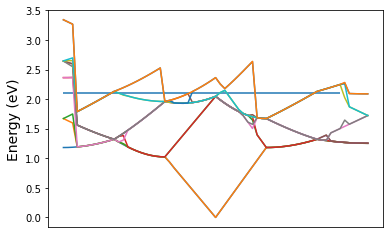

In [6]:
plt.plot(ms_fs.all_freqs*  2*np.pi* 3e8 /0.5e-6 * ħeV)
plt.ylabel("Energy (eV)", fontsize=14)
plt.hlines(2.1, 0, 60)
plt.xlabel("")
plt.xticks([])
# np.savez("phc_an_files/phc3d_bands_iop_air_holes_book.npz", ms.all_freqs)

In [ ]:
converter = mpb.MPBData(rectify=True, periods=3, resolution=ms.resolution[0]/2, lattice=ms.get_lattice())
plt.pcolormesh(np.abs(converter.convert(eps)[15]))
plt.colorbar()

In [37]:
num_sample = 15
BZ_sample = np.linspace(-0.75,0.75, num_sample)
print(BZ_sample)

# number of points in mode integral to keep (which is in Fourier space, remember)
N_offset = 7
vol_FCC = 1/4

Mx_vals = np.zeros([num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
My_vals = np.zeros([num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
Mz_vals = np.zeros([num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
omega_vals = np.zeros([num_bands, num_sample, num_sample, num_sample])
vg_vals = np.zeros([num_bands, num_sample, num_sample, num_sample])
# converter = mpb.MPBData(rectify=True, periods=1, resolution=ms.resolution[0], lattice=ms.get_lattice())


for (l, kx) in enumerate(BZ_sample):
    for (m, ky) in enumerate(BZ_sample):
        for (n, kz) in enumerate(BZ_sample):
            if not (near_1BZ_FCC(FCC_to_cartesian_r @ [kx, ky, kz])):
                continue
            print(time.asctime(time.localtime()))
            print("(l, m, n) = ")
            print("(", str(l), str(m), str(n), ")")
            k = mp.Vector3(kx, ky, kz)
            E, omega, vgmag = get_mode_info(ms_fs, k)
            Mbands = []
            for i in range(num_bands):
                Ex = np.array(E[i,0,:,:,:])
                Ey = np.array(E[i,1,:,:,:])
                Ez = np.array(E[i,2,:,:,:])
                Mx = get_M_grid(Ex, material_region_fs, N_offset, vol_FCC)
                My = get_M_grid(Ey, material_region_fs, N_offset, vol_FCC)
                Mz = get_M_grid(Ez, material_region_fs, N_offset, vol_FCC)
                Mx_vals[i,l,m,n,:,:,:] = Mx
                My_vals[i,l,m,n,:,:,:] = My
                Mz_vals[i,l,m,n,:,:,:] = Mz
            omega_vals[:,l,m,n] = omega
            vg_vals[:,l,m,n] = vgmag

[-0.75       -0.64285714 -0.53571429 -0.42857143 -0.32142857 -0.21428571
 -0.10714286  0.          0.10714286  0.21428571  0.32142857  0.42857143
  0.53571429  0.64285714  0.75      ]
Fri Jun 28 16:01:04 2024
(l, m, n) = 
( 0 0 3 )
Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
     (1, 1, -1)
Geometric objects:
Geometric object tree has depth 1 and 0 object nodes (vs. 0 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<-0.75, -0.75, -0.4285714285714286>
elapsed time for initialization: 0.027602434158325195
solve_kpoint (-0.75,-0.75,-0.428571):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1,

/home/elinas/miniconda3/envs/mp/lib/python3.7/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
/home/elinas/miniconda3/envs/mp/lib/python3.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/home/elinas/miniconda3/envs/mp/lib/python3.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


    linmin: converged after 3 iterations.
    iteration   10: trace = 1.684724764064588 (0.2234% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   11: trace = 1.683442963307116 (0.0761126% change)
    iteration   12: trace = 1.682742318767834 (0.0416284% change)
    iteration   13: trace = 1.682395827322626 (0.020593% change)
    iteration   14: trace = 1.682226856753563 (0.010044% change)
    iteration   15: trace = 1.682186092410692 (0.00242327% change)
    iteration   16: trace = 1.682175902225608 (0.000605772% change)
    iteration   17: trace = 1.682172072849109 (0.000227644% change)
    switching back to exact line minimization
    iteration   18: trace = 1.682170695621855 (8.1872e-05% change)
    linmin: converged after 2 iterations.
    iteration   19: trace = 1.682169965310584 (4.34148e-05% change)
    linmin: converged after 2 iterations.
    iteration   20: trace = 1.682169634444188 (1.966

    linmin: converged after 4 iterations.
    iteration   12: trace = 3.610542592672882 (0.0147766% change)
    linmin: converged after 4 iterations.
    iteration   13: trace = 3.610384058973865 (0.00439095% change)
    linmin: converged after 4 iterations.
    iteration   14: trace = 3.6103163600419 (0.00187513% change)
    linmin: converged after 4 iterations.
    iteration   15: trace = 3.610264611013227 (0.00143338% change)
    linmin: converged after 4 iterations.
    iteration   16: trace = 3.610221257614927 (0.00120084% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 3.610198866985622 (0.000620203% change)
    linmin: converged after 2 iterations.
    iteration   18: trace = 3.610189430475196 (0.000261385% change)
    linmin: converged after 2 iterations.
    iteration   19: trace = 3.61018701370889 (6.69429e-05% change)
    linmin: converged after 2 iterations.
    iteration   20: trace = 3.610186441384514 (1.5853e-05% change)
    linmin: converge

Fixing e-field (band 12) phase by -0.0476 + -0.998866i; max ampl. = 0.734072
total elapsed time for run: 0.5495517253875732
done
Fri Jun 28 16:01:07 2024
(l, m, n) = 
( 0 2 1 )
Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
     (1, 1, -1)
Geometric objects:
Geometric object tree has depth 1 and 0 object nodes (vs. 0 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<-0.75, -0.5357142857142857, -0.6428571428571429>
elapsed time for initialization: 0.020622730255126953
solve_kpoint (-0.75,-0.535714,-0.642857):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band

Finished solving for bands 1 to 6 after 12 iterations.
Solving for bands 7 to 12...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 18.3713592952839 (173.64% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 4.704350060169858 (118.454% change)
    linmin: converged after 7 iterations.
    iteration    3: trace = 3.761107044447796 (22.2845% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 3.591146150042141 (4.62337% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 3.545523546643554 (1.27854% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 3.516926961885945 (0.80982% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 3.49711538792723 (0.564912% change)
    iteration    8: trace = 3.490221831401991 (0.197316% change)
    switching 

    iteration   24: trace = 3.438384006441495 (8.75258e-05% change)
    iteration   25: trace = 3.438382712333082 (3.76371e-05% change)
    iteration   26: trace = 3.438382454046487 (7.51186e-06% change)
Finished solving for bands 7 to 12 after 26 iterations.
Finished k-point with 21.5 mean iterations/band.
freqs:, 1, -0.75, -0.535714, -0.428571, 1.09265, 0.41658, 0.41658, 0.520308, 0.520308, 0.606549, 0.60655, 0.63269, 0.63269, 0.771142, 0.771142, 0.85102, 0.85102
elapsed time for k point: 0.6040706634521484
Fixing e-field (band 1) phase by -0.437481 + 0.899228i; max ampl. = 0.767516
Fixing e-field (band 2) phase by 0.411865 + -0.911245i; max ampl. = 0.729118
Fixing e-field (band 3) phase by -0.421727 + 0.906723i; max ampl. = 0.507672
Fixing e-field (band 4) phase by 0.929404 + -0.369065i; max ampl. = 0.689578
Fixing e-field (band 5) phase by 0.356741 + -0.934203i; max ampl. = 0.818484
Fixing e-field (band 6) phase by -0.949573 + 0.313547i; max ampl. = 0.814599
Fixing e-field (band 7)

Fixing e-field (band 5) phase by -0.96534 + 0.260996i; max ampl. = 0.859658
Fixing e-field (band 6) phase by 0.799353 + 0.600862i; max ampl. = 0.784986
Fixing e-field (band 7) phase by -0.24602 + 0.969265i; max ampl. = 0.876534
Fixing e-field (band 8) phase by 0.91857 + -0.395259i; max ampl. = 0.795615
Fixing e-field (band 9) phase by -0.0405511 + -0.999177i; max ampl. = 0.894329
Fixing e-field (band 10) phase by -0.799373 + 0.600835i; max ampl. = 0.740042
Fixing e-field (band 11) phase by -0.240082 + -0.970753i; max ampl. = 0.934122
Fixing e-field (band 12) phase by -0.847648 + -0.53056i; max ampl. = 0.807063
total elapsed time for run: 0.852426290512085
done
Fri Jun 28 16:01:10 2024
(l, m, n) = 
( 0 2 5 )
Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0

    linmin: converged after 2 iterations.
    iteration   10: trace = 1.543338425349509 (1.68225e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
Solving for bands 7 to 12...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 17.89460495978766 (174.39% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 4.76490111108011 (115.887% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 3.961535026874105 (18.4122% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 3.806915943313796 (3.98069% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 3.774467980802721 (0.85599% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 3.758624892956685 (0.420626% change)
    iteration    7: trace = 3.750390113045652 (0.21933% change)
    switch

Fixing e-field (band 5) phase by 0.354307 + -0.935129i; max ampl. = 0.727061
Fixing e-field (band 6) phase by 0.918249 + -0.396003i; max ampl. = 0.644095
Fixing e-field (band 7) phase by -0.907866 + -0.41926i; max ampl. = 0.929496
Fixing e-field (band 8) phase by -0.986716 + 0.162456i; max ampl. = 0.889049
Fixing e-field (band 9) phase by -0.999198 + 0.0400393i; max ampl. = 0.66895
Fixing e-field (band 10) phase by -0.516625 + -0.856212i; max ampl. = 0.670426
Fixing e-field (band 11) phase by -0.0970105 + 0.995283i; max ampl. = 0.617668
Fixing e-field (band 12) phase by -0.824077 + -0.566478i; max ampl. = 0.703326
total elapsed time for run: 0.5267767906188965
done
Fri Jun 28 16:01:12 2024
(l, m, n) = 
( 0 3 2 )
Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volum

    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 1.546419411238803 (0.156336% change)
    iteration    7: trace = 1.546247640928537 (0.0111082% change)
    switching back to exact line minimization
    iteration    8: trace = 1.546232208156605 (0.000998084% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 1.546230841017171 (8.84175e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 1.546230744725289 (6.22752e-06% change)
Finished solving for bands 1 to 6 after 10 iterations.
Solving for bands 7 to 12...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 18.7435610267653 (173.151% change)
    linmin: converged after 10 iterations.
    iteration    2: trace = 4.637057214102526 (120.668% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 3.684109055713442 (22.9042% ch

Fixing e-field (band 10) phase by 0.999443 + -0.0333704i; max ampl. = 0.681129
Fixing e-field (band 11) phase by -0.722478 + 0.691394i; max ampl. = 0.639739
Fixing e-field (band 12) phase by -0.742539 + 0.669803i; max ampl. = 0.689336
total elapsed time for run: 0.415604829788208
done
Fri Jun 28 16:01:13 2024
(l, m, n) = 
( 0 3 5 )
Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
     (1, 1, -1)
Geometric objects:
Geometric object tree has depth 1 and 0 object nodes (vs. 0 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<-0.75, -0.4285714285714286, -0.2142857142857143>
elapsed time for initi

Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
     (1, 1, -1)
Geometric objects:
Geometric object tree has depth 1 and 0 object nodes (vs. 0 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<-0.75, -0.4285714285714286, -0.1071428571428572>
elapsed time for initialization: 0.020975112915039062
solve_kpoint (-0.75,-0.428571,-0.107143):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8, band 9, band 10, band 11, band 12
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 9.765447168986691 (185.565% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 2.00090465699609 (131.979% change)
    linmin:

    iteration   10: trace = 1.550285235103147 (0.00191248% change)
    iteration   11: trace = 1.550281060794923 (0.000269261% change)
    iteration   12: trace = 1.550280166514066 (5.76851e-05% change)
    iteration   13: trace = 1.550280001096366 (1.06702e-05% change)
    iteration   14: trace = 1.550279980904312 (1.30248e-06% change)
Finished solving for bands 1 to 6 after 14 iterations.
Solving for bands 7 to 12...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 17.82958892752296 (174.406% change)
    linmin: converged after 10 iterations.
    iteration    2: trace = 4.663323834589236 (117.07% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 3.847097218176944 (19.1818% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 3.678514300852593 (4.48025% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 3.620803072810703 (1.58128% change)
    linmin: converged

    linmin: converged after 5 iterations.
    iteration    4: trace = 3.588454488310121 (5.78097% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    5: trace = 3.542604237656794 (1.28593% change)
    iteration    6: trace = 3.518802677513696 (0.674131% change)
    iteration    7: trace = 3.501045690455354 (0.505908% change)
    switching back to exact line minimization
    iteration    8: trace = 3.49664950269881 (0.125647% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    9: trace = 3.494874547417562 (0.0507745% change)
    iteration   10: trace = 3.492177837100658 (0.0771916% change)
    iteration   11: trace = 3.489349537640171 (0.0810224% change)
    switching back to exact line minimization
    iteration   12: trace = 3.48820783426891 (0.032725% change)
    linmin: converged after 4 iterations.
    iteration 

Fixing e-field (band 2) phase by 0.131384 + -0.991332i; max ampl. = 0.934477
Fixing e-field (band 3) phase by -0.912528 + 0.409015i; max ampl. = 1.03841
Fixing e-field (band 4) phase by 0.822509 + -0.568751i; max ampl. = 1.16229
Fixing e-field (band 5) phase by -0.516995 + 0.855989i; max ampl. = 1.27917
Fixing e-field (band 6) phase by 0.579642 + -0.814871i; max ampl. = 0.980929
Fixing e-field (band 7) phase by 0.856041 + -0.516908i; max ampl. = 0.787323
Fixing e-field (band 8) phase by -0.97061 + 0.240658i; max ampl. = 0.913256
Fixing e-field (band 9) phase by 0.109487 + -0.993988i; max ampl. = 0.78665
Fixing e-field (band 10) phase by 0.143713 + -0.989619i; max ampl. = 0.665351
Fixing e-field (band 11) phase by -0.904246 + 0.427012i; max ampl. = 0.586704
Fixing e-field (band 12) phase by -0.798286 + -0.602279i; max ampl. = 0.77406
total elapsed time for run: 0.5749635696411133
done
Fri Jun 28 16:01:17 2024
(l, m, n) = 
( 0 4 4 )
Initializing eigensolver data
Computing 12 bands with 1

    iteration   15: trace = 1.624324020870917 (0.000165463% change)
    linmin: converged after 2 iterations.
    iteration   16: trace = 1.624323378557993 (3.95434e-05% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 1.624323274736536 (6.39167e-06% change)
Finished solving for bands 1 to 6 after 17 iterations.
Solving for bands 7 to 12...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 17.30259528898817 (175.223% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 4.719998698129205 (114.27% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 3.817947158160204 (21.1304% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 3.591500234956864 (6.11238% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 3.500196356829169 (2.57495% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 3.4

    linmin: converged after 4 iterations.
    iteration   16: trace = 3.612997323749766 (0.0882764% change)
    linmin: converged after 3 iterations.
    iteration   17: trace = 3.61148148332564 (0.041964% change)
    linmin: converged after 3 iterations.
    iteration   18: trace = 3.61093862983048 (0.0150325% change)
    linmin: converged after 3 iterations.
    iteration   19: trace = 3.610677939815858 (0.00721971% change)
    linmin: converged after 3 iterations.
    iteration   20: trace = 3.610504122216364 (0.0048141% change)
    linmin: converged after 3 iterations.
    iteration   21: trace = 3.610348085559878 (0.00432183% change)
    linmin: converged after 3 iterations.
    iteration   22: trace = 3.61025103478444 (0.00268816% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   23: trace = 3.610217526161074 (0.000928156% change)
    iteration   24: trace = 3.610203964670553 (0.000375643% chan

Fixing e-field (band 9) phase by -0.137357 + 0.990522i; max ampl. = 0.896649
Fixing e-field (band 10) phase by -0.464292 + 0.885682i; max ampl. = 0.75363
Fixing e-field (band 11) phase by 0.475012 + -0.879979i; max ampl. = 0.915667
Fixing e-field (band 12) phase by -0.983756 + -0.179511i; max ampl. = 0.997473
total elapsed time for run: 0.5025708675384521
done
Fri Jun 28 16:01:19 2024
(l, m, n) = 
( 0 5 2 )
Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
     (1, 1, -1)
Geometric objects:
Geometric object tree has depth 1 and 0 object nodes (vs. 0 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Ve

    iteration   17: trace = 1.63878480547826 (1.42528e-05% change)
    linmin: converged after 2 iterations.
    iteration   18: trace = 1.638784772139807 (2.03434e-06% change)
Finished solving for bands 1 to 6 after 18 iterations.
Solving for bands 7 to 12...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 17.24899751219773 (175.244% change)
    linmin: converged after 10 iterations.
    iteration    2: trace = 4.593809250340083 (115.875% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 3.799905357260035 (18.9166% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 3.624508510868839 (4.72487% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    5: trace = 3.574411928372958 (1.39178% change)
    iteration    6: trace = 3.53539332808691 (1.0976% change)
    switching back to exact line minimization
   

    iteration    4: trace = 3.553720565912165 (6.76855% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 3.488876440644655 (1.84148% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    6: trace = 3.472979779169435 (0.456679% change)
    iteration    7: trace = 3.468814610402793 (0.120003% change)
    switching back to exact line minimization
    iteration    8: trace = 3.466490623766792 (0.067019% change)
    large trace change predicted (0.205194%)
    linmin: converged after 5 iterations.
    iteration    9: trace = 3.460001790695345 (0.187363% change)
    linmin: converged after 5 iterations.
    iteration   10: trace = 3.448850190755969 (0.322821% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   11: trace = 3.444780415368857 (0.118073% change)
    iteration   12: trace = 3.443254435

    iteration   17: trace = 3.485240960059846 (0.000188992% change)
    linmin: converged after 2 iterations.
    iteration   18: trace = 3.485238561962709 (6.88072e-05% change)
    linmin: converged after 2 iterations.
    iteration   19: trace = 3.485237991922436 (1.63558e-05% change)
    linmin: converged after 2 iterations.
    iteration   20: trace = 3.485237739197229 (7.2513e-06% change)
Finished solving for bands 7 to 12 after 20 iterations.
Finished k-point with 17 mean iterations/band.
freqs:, 1, -0.75, -0.214286, -0.214286, 1.10829, 0.364359, 0.364359, 0.527759, 0.527759, 0.651385, 0.651385, 0.710836, 0.710836, 0.710836, 0.710836, 0.855596, 0.855596
elapsed time for k point: 0.5376415252685547
Fixing e-field (band 1) phase by -0.560674 + -0.828037i; max ampl. = 0.716831
Fixing e-field (band 2) phase by 0.891573 + -0.452876i; max ampl. = 0.687162
Fixing e-field (band 3) phase by 0.420694 + -0.907203i; max ampl. = 0.688976
Fixing e-field (band 4) phase by 0.794355 + 0.607453i; 

freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8, band 9, band 10, band 11, band 12
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 9.874413991472316 (185.42% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 1.916246546814157 (134.991% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 1.653117172602384 (14.7438% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    4: trace = 1.593333159681491 (3.68304% change)
    iteration    5: trace = 1.561724110103277 (2.00371% change)
    iteration    6: trace = 1.552352428477823 (0.601892% change)
    iteration    7: trace = 1.550518491177265 (0.118209% change)
    iteration    8: trace = 1.550315758314152 (0.013076% change)
    iteration    9: trace = 1.550286580757983 (0.0018820

    iteration    7: trace = 3.635465714097161 (0.167057% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 3.630664542917727 (0.132152% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 3.62307154187952 (0.209354% change)
    linmin: converged after 3 iterations.
    iteration   10: trace = 3.615640281749426 (0.20532% change)
    linmin: converged after 3 iterations.
    iteration   11: trace = 3.612507562578131 (0.0866811% change)
    linmin: converged after 3 iterations.
    iteration   12: trace = 3.611454179245656 (0.0291636% change)
    linmin: converged after 3 iterations.
    iteration   13: trace = 3.610996693855512 (0.0126684% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   14: trace = 3.610720897981836 (0.00763796% change)
    iteration   15: trace = 3.61042415824543 (0.00821863% change)
    iteration   16: trace = 3.610263084187626 

Fixing e-field (band 2) phase by 0.255864 + -0.966713i; max ampl. = 0.869891
Fixing e-field (band 3) phase by 0.206188 + 0.978512i; max ampl. = 0.783723
Fixing e-field (band 4) phase by -0.813727 + -0.581247i; max ampl. = 0.875965
Fixing e-field (band 5) phase by -0.451426 + -0.892309i; max ampl. = 0.75181
Fixing e-field (band 6) phase by 0.832453 + 0.554096i; max ampl. = 0.859258
Fixing e-field (band 7) phase by -0.99895 + -0.0458162i; max ampl. = 0.900947
Fixing e-field (band 8) phase by 0.979949 + 0.199248i; max ampl. = 0.928795
Fixing e-field (band 9) phase by 0.997434 + 0.071594i; max ampl. = 0.708163
Fixing e-field (band 10) phase by 0.250826 + -0.968032i; max ampl. = 0.607981
Fixing e-field (band 11) phase by -0.180242 + 0.983622i; max ampl. = 0.697788
Fixing e-field (band 12) phase by -0.931266 + -0.36434i; max ampl. = 0.671415
total elapsed time for run: 0.5667357444763184
done
Fri Jun 28 16:01:24 2024
(l, m, n) = 
( 0 7 4 )
Initializing eigensolver data
Computing 12 bands wit

    iteration    8: trace = 1.682888976970158 (0.185747% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 1.682344520832987 (0.0323577% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   10: trace = 1.682230528577926 (0.00677603% change)
    iteration   11: trace = 1.682184869731144 (0.00271422% change)
    iteration   12: trace = 1.682171882917792 (0.000772024% change)
    iteration   13: trace = 1.6821699340098 (0.000115857% change)
    iteration   14: trace = 1.682169619156619 (1.87171e-05% change)
    iteration   15: trace = 1.682169513542841 (6.27843e-06% change)
Finished solving for bands 1 to 6 after 15 iterations.
Solving for bands 7 to 12...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 19.5502742246951 (171.964% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 4.97555304769863 (118.852

    iteration   15: trace = 3.610283472061896 (0.00187051% change)
    iteration   16: trace = 3.61021797188842 (0.00181428% change)
    iteration   17: trace = 3.610194432597315 (0.000652021% change)
    iteration   18: trace = 3.610188699619993 (0.0001588% change)
    switching back to exact line minimization
    iteration   19: trace = 3.610187282359428 (3.92573e-05% change)
    linmin: converged after 2 iterations.
    iteration   20: trace = 3.610186681605479 (1.66405e-05% change)
    linmin: converged after 2 iterations.
    iteration   21: trace = 3.610186154404042 (1.46032e-05% change)
    linmin: converged after 2 iterations.
    iteration   22: trace = 3.610185745153744 (1.1336e-05% change)
    linmin: converged after 2 iterations.
    iteration   23: trace = 3.61018561854723 (3.50693e-06% change)
Finished solving for bands 7 to 12 after 23 iterations.
Finished k-point with 17 mean iterations/band.
freqs:, 1, -0.642857, -0.75, -0.428571, 1.14898, 0.391895, 0.391895, 0.547133,

Fixing e-field (band 6) phase by -0.477563 + 0.878598i; max ampl. = 0.608599
Fixing e-field (band 7) phase by 0.992929 + -0.118706i; max ampl. = 0.749397
Fixing e-field (band 8) phase by 0.999646 + 0.0266205i; max ampl. = 0.683509
Fixing e-field (band 9) phase by 0.489019 + 0.872273i; max ampl. = 0.723916
Fixing e-field (band 10) phase by 0.348515 + 0.937303i; max ampl. = 0.635982
Fixing e-field (band 11) phase by -0.531402 + 0.84712i; max ampl. = 0.681359
Fixing e-field (band 12) phase by 0.00901821 + -0.999959i; max ampl. = 0.639795
total elapsed time for run: 0.8056185245513916
done
Fri Jun 28 16:01:27 2024
(l, m, n) = 
( 1 1 1 )
Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
   

    linmin: converged after 2 iterations.
    iteration   12: trace = 1.708200901945479 (0.000148515% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 1.708200377158217 (3.07216e-05% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 1.708200301925671 (4.4042e-06% change)
Finished solving for bands 1 to 6 after 14 iterations.
Solving for bands 7 to 12...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 19.06567557901488 (172.818% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 4.958712234749583 (117.439% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 4.054123365156585 (20.0733% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 3.860335277169289 (4.89706% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 3.790383123327655 (1.82864% change)
    linmin: converged after 3 i

Fixing e-field (band 8) phase by -0.863545 + 0.504272i; max ampl. = 0.803646
Fixing e-field (band 9) phase by -0.195436 + 0.980717i; max ampl. = 0.859178
Fixing e-field (band 10) phase by 0.909903 + 0.414821i; max ampl. = 0.753372
Fixing e-field (band 11) phase by 0.8674 + -0.497611i; max ampl. = 0.765876
Fixing e-field (band 12) phase by 0.789174 + 0.614169i; max ampl. = 0.765323
total elapsed time for run: 0.45059967041015625
done
Fri Jun 28 16:01:29 2024
(l, m, n) = 
( 1 1 4 )
Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
     (1, 1, -1)
Geometric objects:
Geometric object tree has depth 1 and 0 object nodes (vs. 0 actual objects)
Initializing epsilon function...
Solving for ban

    switching back to exact line minimization
    linmin: converged after 5 iterations.
    iteration    5: trace = 3.350057633842105 (4.01297% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 3.262203455966361 (2.65731% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 3.245384931125062 (0.51689% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 3.24224284332028 (0.096864% change)
    linmin: converged after 4 iterations.
    iteration    9: trace = 3.24176320457898 (0.0147945% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 3.241714067862703 (0.00151575% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 3.241706104594897 (0.00024565% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 3.241704979639263 (3.47026e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 3.241704866354363 (3.4946

Fixing e-field (band 4) phase by 0.348067 + 0.93747i; max ampl. = 0.876828
Fixing e-field (band 5) phase by -0.690517 + 0.723316i; max ampl. = 0.726324
Fixing e-field (band 6) phase by 0.170973 + 0.985276i; max ampl. = 0.752149
Fixing e-field (band 7) phase by -0.918543 + -0.395321i; max ampl. = 0.815738
Fixing e-field (band 8) phase by -0.729441 + -0.684044i; max ampl. = 0.84527
Fixing e-field (band 9) phase by 0.123505 + 0.992344i; max ampl. = 0.648439
Fixing e-field (band 10) phase by 0.999917 + -0.0128524i; max ampl. = 0.651585
Fixing e-field (band 11) phase by -0.842396 + 0.538858i; max ampl. = 0.695432
Fixing e-field (band 12) phase by 0.722388 + 0.691488i; max ampl. = 0.710915
total elapsed time for run: 0.7473726272583008
done
Fri Jun 28 16:01:31 2024
(l, m, n) = 
( 1 2 1 )
Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vecto

    linmin: converged after 3 iterations.
    iteration    9: trace = 1.76366904041764 (0.0559606% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 1.763437079234266 (0.0131531% change)
    linmin: converged after 4 iterations.
    iteration   11: trace = 1.76331342605009 (0.0070123% change)
    linmin: converged after 4 iterations.
    iteration   12: trace = 1.763200052562274 (0.00642978% change)
    linmin: converged after 4 iterations.
    iteration   13: trace = 1.763162436299393 (0.00213343% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 1.763156334700222 (0.000346061% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 1.76315543959743 (5.07671e-05% change)
    linmin: converged after 2 iterations.
    iteration   16: trace = 1.763154852313715 (3.33087e-05% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 1.763154322844771 (3.00296e-05% change)
    linmin: converged

    linmin: converged after 2 iterations.
    iteration   22: trace = 1.652668013309472 (7.80877e-06% change)
Finished solving for bands 1 to 6 after 22 iterations.
Solving for bands 7 to 12...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 18.64990319767949 (173.33% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 5.108558186286708 (113.992% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 4.041396985755166 (23.326% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 3.76493494278785 (7.08302% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 3.652092587428015 (3.04279% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 3.555139584269333 (2.69044% change)
    linmin: converged after 5 iterations.
    iteration    7: trace = 3.51221639520312 (1.21469% change)
    linmin: converged after 3 iterations.


Fixing e-field (band 5) phase by 0.422987 + -0.906136i; max ampl. = 0.737667
Fixing e-field (band 6) phase by -0.359774 + 0.93304i; max ampl. = 0.674372
Fixing e-field (band 7) phase by 0.698867 + -0.715251i; max ampl. = 0.647404
Fixing e-field (band 8) phase by -0.792228 + 0.610225i; max ampl. = 0.685405
Fixing e-field (band 9) phase by -0.49874 + 0.866752i; max ampl. = 0.748382
Fixing e-field (band 10) phase by 0.245676 + 0.969352i; max ampl. = 0.646448
Fixing e-field (band 11) phase by 0.569068 + -0.822291i; max ampl. = 0.664144
Fixing e-field (band 12) phase by -0.852845 + 0.522165i; max ampl. = 0.776417
total elapsed time for run: 0.5548832416534424
done
Fri Jun 28 16:01:33 2024
(l, m, n) = 
( 1 2 5 )
Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.

    linmin: converged after 4 iterations.
    iteration    6: trace = 2.985040575701824 (0.0822411% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 2.9848779040752 (0.00544971% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.984867918882548 (0.000334527% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 2.984867443368802 (1.59308e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 2.984867414782525 (9.57707e-07% change)
Finished solving for bands 7 to 12 after 10 iterations.
Finished k-point with 10 mean iterations/band.
freqs:, 1, -0.642857, -0.535714, -0.107143, 1.09265, 0.453798, 0.453798, 0.520308, 0.520308, 0.606549, 0.606549, 0.606549, 0.606549, 0.749844, 0.749844, 0.749844, 0.749844
elapsed time for k point: 0.31327128410339355
Fixing e-field (band 1) phase by -0.615691 + 0.787988i; max ampl. = 0.920176
Fixing e-field (band 2) phase by -0.742731 + -0.66959i; m

KeyboardInterrupt: 

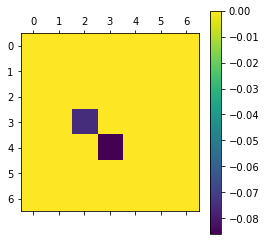

In [39]:
plt.matshow(np.real(Mx[3]))
plt.colorbar()

In [ ]:
np.savez("phc_an_files/phc3d_fcc_fs_e_wdpl_ga_noabs.npz", BZ_sample, Mx_vals, My_vals, Mz_vals, omega_vals, vg_vals)

In [ ]:
E, omega, vgmag = get_mode_info(ms_fs, mp.Vector3(0.1, 0.1, 0.1))

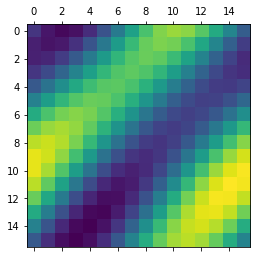

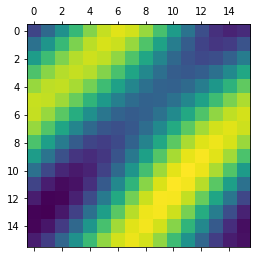

In [8]:
plt.matshow(np.real(Ex[8]))
plt.matshow(np.imag(Ex[8]))

In [7]:
Mx = get_M_grid(Ex, material_region, N_offset, vol_FCC)
plt.matshow(np.abs(Mx[4] + My[4] + Mz[4]))
plt.colorbar()

NameError: name 'Ex' is not defined

In [ ]:
num_sample = 1
BZ_sample = np.linspace(-0.25,0.75, num_sample)
converter = mpb.MPBData(rectify=True, periods=1, resolution=ms.resolution[0], lattice=ms.get_lattice())

for (l, kx) in enumerate(BZ_sample):
    for (m, ky) in enumerate(BZ_sample):
        for (n, kz) in enumerate(BZ_sample):
            k = mp.Vector3(kx, ky, kz)
            H = get_h_info(ms, k)
            for i in range(num_bands):
                Hx = np.array(H[i,0,:,:,:])
                Hy = np.array(H[i,1,:,:,:])
                Hz = np.array(H[i,2,:,:,:])

In [ ]:
np.sum(np.multiply(np.power(np.abs(E[5]),2), np.abs(eps)))/12**3/4/sqr2**3

In [ ]:
plt.imshow(np.abs(eps[5]))

In [ ]:
np.sum(np.power(np.abs(H[4]), 2))/12**3/4/sqr2**3

### Woodpile

In [8]:
geometry_lattice = mp.Lattice(basis_size=mp.Vector3(np.sqrt(0.5), np.sqrt(0.5), np.sqrt(0.5)),
                             basis1=mp.Vector3(0,1,1),
                             basis2=mp.Vector3(1,0,1),
                             basis3=mp.Vector3(1,1,0))

def c(cart):
    return mp.cartesian_to_lattice(cart, geometry_lattice)
w = 0.2
h = 0.25
resolution = 16
ϵ_wdpl_ga = 4.41

default_material = mp.Medium(epsilon=1.0)
k_points = [
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # U
    mp.Vector3(0.5, 0.5, 0.5),      # L
    mp.Vector3(0, 0, 0),            # Gamma
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # W
    mp.Vector3(0.375, 0.75, 0.375)  # K
]
k_points = mp.interpolate(10, k_points)
# ms.geometry = []
geometry = [mp.Block(center=c(mp.Vector3(0,0,0)), material=mp.Medium(epsilon=13.0), 
                     e1=c(mp.Vector3(1,1,0)),
                     e2=c(mp.Vector3(1,-1,0)),
                     e3=c(mp.Vector3(0,0,1)),
                     size=mp.Vector3(mp.inf, w, h)),
            mp.Block(center=c(mp.Vector3(0.125, 0.125, h)), material=mp.Medium(epsilon=13.0), 
                     e1=c(mp.Vector3(1,1,0)),
                     e2=c(mp.Vector3(1,-1,0)),
                     e3=c(mp.Vector3(0,0,1)),
                     size=mp.Vector3(w, mp.inf, h))
           ]

ms = mpb.ModeSolver(
    geometry=geometry,
    default_material=mp.Medium(epsilon=1.0),
    geometry_lattice=geometry_lattice,
    k_points=k_points,
    resolution=resolution,
    num_bands=num_bands
)

ms.run()
eps = np.array(ms.get_epsilon(), dtype=complex)
material_region = get_material_region(eps)

Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
     (1, 1, -1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,0.2,0.25)
          axes (0,0,1.41421), (-1.41421,1.41421,0), (1,1,-1)
     block, center = (0.25,0.25,0)
          size (0.2,1e+20,0.25)
          axes (0,0,1.41421), (-1.41421,1.41421,0), (1,1,-1)
Geometric object tree has depth 1 and 12 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zeven.
Initializing fields to random numbers...
67 k-points
  Vector3<0.0, 0.5, 0.5>
  Vector3<0.022727272727272728, 0.5227272727272727, 0.5>
  Vector3<0.045454545454545456, 0.5454545454545454, 0.5

    linmin: converged after 6 iterations.
    iteration   30: trace = 9.654433653399543 (9.03825e-05% change)
    linmin: converged after 8 iterations.
    iteration   31: trace = 9.654424636092486 (9.34007e-05% change)
    linmin: converged after 6 iterations.
    iteration   32: trace = 9.654415230447853 (9.74232e-05% change)
    linmin: converged after 6 iterations.
    iteration   33: trace = 9.654405482802673 (0.000100966% change)
    linmin: converged after 10 iterations.
    iteration   34: trace = 9.65439536237254 (0.000104827% change)
    linmin: converged after 7 iterations.
    iteration   35: trace = 9.654384879024049 (0.000108586% change)
    linmin: converged after 7 iterations.
    iteration   36: trace = 9.654373965417671 (0.000113043% change)
    linmin: converged after 10 iterations.
    iteration   37: trace = 9.654362694965638 (0.000116739% change)
    linmin: converged after 8 iterations.
    iteration   38: trace = 9.654350981170829 (0.000121332% change)
    linmi

    linmin: converged after 3 iterations.
    iteration   14: trace = 14.12676310904743 (5.2672e-06% change)
Finished solving for bands 7 to 12 after 14 iterations.
Finished k-point with 51.5 mean iterations/band.
zevenfreqs:, 1, 0, 0.5, 0.5, 1, 0.772653, 1.00467, 1.16275, 1.27406, 1.4272, 1.70714, 1.34208, 1.37543, 1.54536, 1.58764, 1.63928, 1.68457
elapsed time for k point: 1.5206623077392578
solve_kpoint (0.0227273,0.522727,0.5):
Solving for bands 1 to 6...
    linmin: converged after 9 iterations.
    iteration    1: trace = 2.963254412929631 (104.503% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 2.551567038736298 (14.9302% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    3: trace = 2.428130574843507 (4.95759% change)
    iteration    4: trace = 2.356996085300271 (2.97315% change)
    switching back to exact line minimization
    iteration    5: trace = 2.290226

    iteration   28: trace = 3.66320597815877 (9.06676e-05% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   29: trace = 3.663204266695714 (4.67204e-05% change)
    iteration   30: trace = 3.66320328507592 (2.67968e-05% change)
    iteration   31: trace = 3.663202687934829 (1.63011e-05% change)
    switching back to exact line minimization
    iteration   32: trace = 3.66320227104722 (1.13804e-05% change)
    linmin: converged after 2 iterations.
    iteration   33: trace = 3.663201995331846 (7.52662e-06% change)
Finished solving for bands 7 to 12 after 33 iterations.
Finished k-point with 38 mean iterations/band.
freqs:, 2, 0.0227273, 0.522727, 0.5, 1.00103, 0.453703, 0.460625, 0.611937, 0.625198, 0.695521, 0.702262, 0.707554, 0.717115, 0.782478, 0.788264, 0.833649, 0.848359
elapsed time for k point: 1.1488356590270996
solve_kpoint (0.0454545,0.545455,0.5):
Solving for bands 1 to 6...
    linmin: co

Finished solving for bands 7 to 12 after 15 iterations.
Finished k-point with 14.5 mean iterations/band.
freqs:, 4, 0.0681818, 0.568182, 0.5, 1.00925, 0.455022, 0.461857, 0.614317, 0.627175, 0.682297, 0.689774, 0.713758, 0.723002, 0.784795, 0.790514, 0.839232, 0.852508
elapsed time for k point: 0.40883517265319824
solve_kpoint (0.0909091,0.590909,0.5):
Solving for bands 1 to 6...
    linmin: converged after 4 iterations.
    iteration    1: trace = 2.121845509888661 (0.110669% change)
    linmin: converged after 2 iterations.
    iteration    2: trace = 2.121166595408364 (0.0320015% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 2.120970305993502 (0.00925427% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 2.12088189393485 (0.00416856% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 2.120835039202085 (0.00220923% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 2.1208

    iteration    4: trace = 2.104589008926124 (0.0045306% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    5: trace = 2.104535331292112 (0.00255054% change)
    iteration    6: trace = 2.104521249330745 (0.000669127% change)
    switching back to exact line minimization
    iteration    7: trace = 2.104514015286957 (0.000343739% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.104510713478694 (0.000156892% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 2.104509355470672 (6.45285e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 2.104508435590267 (4.371e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 2.104507921262853 (2.44393e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 2.104507634132304 (1.36436e-05% change)
    linmin: converged af

    linmin: converged after 2 iterations.
    iteration    2: trace = 2.097258370586377 (0.0358161% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 2.097002810718744 (0.0121862% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 2.096850859914046 (0.00724636% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 2.096767727277469 (0.00396472% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 2.096747891144726 (0.000946038% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 2.096737736338992 (0.000484313% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.096733892179098 (0.00018334% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 2.096732508617033 (6.59866e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 2.096731645599569 (4.11601e-05% change)
    linmin: conve

    linmin: converged after 4 iterations.
    iteration    4: trace = 2.094593052402972 (0.010815% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 2.094481628184215 (0.00531975% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 2.094457922818648 (0.00113181% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 2.094446348964258 (0.000552596% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.094442737439749 (0.000172434% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 2.094441704728098 (4.93072e-05% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   10: trace = 2.094441190546197 (2.45498e-05% change)
    iteration   11: trace = 2.094441010555934 (8.59371e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
Solving for bands 7 to 12...
    linmin: 

Finished solving for bands 1 to 6 after 14 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    iteration    1: trace = 3.801732307459665 (0.279007% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    2: trace = 3.7986333003041 (0.0815489% change)
    iteration    3: trace = 3.797732829925335 (0.0237079% change)
    switching back to exact line minimization
    iteration    4: trace = 3.796733991068832 (0.0263044% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 3.796032258479984 (0.0184842% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 3.795650435263199 (0.010059% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 3.795385580052407 (0.0069781% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 3.795270105773637 (0.00304254% change)
    linmin: converged 

    linmin: converged after 2 iterations.
    iteration   14: trace = 2.064106529157409 (3.24069e-05% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   15: trace = 2.064106193386183 (1.62671e-05% change)
    iteration   16: trace = 2.064106061891464 (6.37054e-06% change)
Finished solving for bands 1 to 6 after 16 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    iteration    1: trace = 3.830654806312153 (0.299063% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 3.827186063070037 (0.0905932% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 3.826108926641993 (0.0281483% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 3.824769856690053 (0.0350043% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 3.823843525533692 (0.0242222% change)
    linmin: conver

    linmin: converged after 2 iterations.
    iteration    7: trace = 3.867410338991135 (0.00270078% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 3.867370521385312 (0.00102957% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 3.867352879376668 (0.000456177% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 3.867344207812645 (0.000224225% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 3.867340943563197 (8.44055e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 3.867339233132606 (4.42276e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 3.867338322511872 (2.35464e-05% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 3.867337890733485 (1.11647e-05% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 3.8673376294702 (6.75564e-06% change)
Finished solvi

    iteration   12: trace = 3.921128106161258 (0.000138331% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 3.921123824652347 (0.000109191% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 3.921120138661587 (9.40035e-05% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 3.921115950431617 (0.000106812% change)
    linmin: converged after 2 iterations.
    iteration   16: trace = 3.921110832716327 (0.000130517% change)
    large trace change predicted (0.000266528%)
    linmin: converged after 2 iterations.
    iteration   17: trace = 3.921100383667254 (0.000266482% change)
    large trace change predicted (0.000611781%)
    linmin: converged after 3 iterations.
    iteration   18: trace = 3.921076430436464 (0.000610882% change)
    large trace change predicted (0.00134901%)
    linmin: converged after 3 iterations.
    iteration   19: trace = 3.921023956424553 (0.00133826% change)
    large trace chan

    iteration   22: trace = 3.931659303050762 (0.000375873% change)
    linmin: converged after 2 iterations.
    iteration   23: trace = 3.9316481024442 (0.000284883% change)
    linmin: converged after 2 iterations.
    iteration   24: trace = 3.93164206477343 (0.000153566% change)
    linmin: converged after 2 iterations.
    iteration   25: trace = 3.931638531588235 (8.98654e-05% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   26: trace = 3.93163658726166 (4.94534e-05% change)
    iteration   27: trace = 3.931635582318344 (2.55604e-05% change)
    iteration   28: trace = 3.931635030605957 (1.40326e-05% change)
    switching back to exact line minimization
    iteration   29: trace = 3.931634655176901 (9.54893e-06% change)
Finished solving for bands 7 to 12 after 29 iterations.
Finished k-point with 21.5 mean iterations/band.
freqs:, 20, 0.431818, 0.568182, 0.5, 0.887237, 0.390103, 0.414783, 0.5

    iteration    5: trace = 3.944460917819869 (0.00829855% change)
    iteration    6: trace = 3.944361672831634 (0.00251609% change)
    switching back to exact line minimization
    iteration    7: trace = 3.944296480335553 (0.00165282% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 3.944257489143346 (0.000988551% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 3.944224486449976 (0.000836731% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 3.944196783557824 (0.000702368% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   11: trace = 3.944180873016637 (0.000403392% change)
    iteration   12: trace = 3.944170506489588 (0.000262831% change)
    switching back to exact line minimization
    iteration   13: trace = 3.944165486746043 (0.00012727% change)
    linmin: converged after 2 iterations.
    iteration   14:

    iteration   18: trace = 1.982943024260741 (5.63708e-06% change)
Finished solving for bands 1 to 6 after 18 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    1: trace = 3.948764844910207 (0.182635% change)
    iteration    2: trace = 3.945866299739022 (0.0734308% change)
    switching back to exact line minimization
    iteration    3: trace = 3.94462197971409 (0.0315397% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 3.943622298188441 (0.0253461% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 3.942979127175172 (0.0163105% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 3.942448209353745 (0.0134658% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 3.941784706698272 (0.0168311% change)
    linmin: converged after 4 iterations.
    iteration    8:

Finished k-point with 21 mean iterations/band.
freqs:, 25, 0.409091, 0.409091, 0.409091, 0.708566, 0.350284, 0.375584, 0.584215, 0.602597, 0.711096, 0.717929, 0.729361, 0.788589, 0.789355, 0.795081, 0.866157, 0.876094
elapsed time for k point: 0.5762076377868652
solve_kpoint (0.363636,0.363636,0.363636):
Solving for bands 1 to 6...
    linmin: converged after 3 iterations.
    iteration    1: trace = 2.003713572182437 (0.581825% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 2.000755852927934 (0.147721% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 2.000382848367673 (0.0186449% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 2.000220118675447 (0.00813526% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 2.000145148095974 (0.00374819% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 2.000121919405514 (0.00116136% change)
    linmin: conve

    iteration   14: trace = 3.897064274512181 (9.38098e-05% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 3.897062160117151 (5.42561e-05% change)
    linmin: converged after 2 iterations.
    iteration   16: trace = 3.897061127079511 (2.65081e-05% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 3.897060533571058 (1.52296e-05% change)
    linmin: converged after 2 iterations.
    iteration   18: trace = 3.897060177870577 (9.1274e-06% change)
Finished solving for bands 7 to 12 after 18 iterations.
Finished k-point with 18 mean iterations/band.
freqs:, 27, 0.318182, 0.318182, 0.318182, 0.551107, 0.291452, 0.307647, 0.629369, 0.640475, 0.714102, 0.720908, 0.736915, 0.786265, 0.788197, 0.797171, 0.859413, 0.86051
elapsed time for k point: 0.48715972900390625
solve_kpoint (0.272727,0.272727,0.272727):
Solving for bands 1 to 6...
    linmin: converged after 3 iterations.
    iteration    1: trace = 2.039628184020537 (0.554699% chan

    iteration    9: trace = 3.877533514280518 (0.000396279% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 3.877519667799635 (0.000357096% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 3.877510510251242 (0.000236171% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 3.877503643669514 (0.000177088% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 3.877500129571842 (9.06279e-05% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 3.877498367154679 (4.54524e-05% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 3.87749721195714 (2.97923e-05% change)
    linmin: converged after 2 iterations.
    iteration   16: trace = 3.877496629857147 (1.50123e-05% change)
    linmin: converged after 2 iterations.
    iteration   17: trace = 3.877496307748759 (8.30712e-06% change)
Finished solving for bands 7 to 12 after 17 iteration

    linmin: converged after 4 iterations.
    iteration    1: trace = 3.88916082126382 (0.20594% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 3.886663829431788 (0.0642245% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 3.885781977256867 (0.0226918% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 3.885198082309827 (0.0150276% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 3.88491422481107 (0.00730639% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 3.884802842304898 (0.00286709% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 3.884712140547944 (0.00233481% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 3.884667672221866 (0.00114471% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 3.884639191832019 (0.000733151% change)
    linmin: converged afte

    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   26: trace = 3.893098147790341 (1.60513e-05% change)
    iteration   27: trace = 3.893097752924388 (1.01427e-05% change)
    iteration   28: trace = 3.893097459662408 (7.53287e-06% change)
Finished solving for bands 7 to 12 after 28 iterations.
Finished k-point with 25 mean iterations/band.
freqs:, 32, 0.0909091, 0.0909091, 0.0909091, 0.157459, 0.088914, 0.092484, 0.708162, 0.713773, 0.74206, 0.74226, 0.759528, 0.793156, 0.797086, 0.808057, 0.835975, 0.836638
elapsed time for k point: 0.6368656158447266
solve_kpoint (0.0454545,0.0454545,0.0454545):
Solving for bands 1 to 6...
    linmin: converged after 6 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    1: trace = 2.147636399825977 (0.526247% change)
    iteration    2: trace = 2.145562723629675 (0.0966028% change)
    iteration    3: trace = 2.143492885164276

    linmin: converged after 2 iterations.
    iteration   17: trace = 3.916080600185363 (0.000468393% change)
    linmin: converged after 2 iterations.
    iteration   18: trace = 3.916069952973619 (0.000271885% change)
    linmin: converged after 2 iterations.
    iteration   19: trace = 3.916063309083823 (0.000169657% change)
    linmin: converged after 2 iterations.
    iteration   20: trace = 3.916057980963861 (0.000136058% change)
    linmin: converged after 2 iterations.
    iteration   21: trace = 3.916054688000697 (8.40888e-05% change)
    linmin: converged after 2 iterations.
    iteration   22: trace = 3.916052868122096 (4.64723e-05% change)
    linmin: converged after 2 iterations.
    iteration   23: trace = 3.916051714733387 (2.94528e-05% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   24: trace = 3.916051097536224 (1.57607e-05% change)
    iteration   25: trace = 3.91605066936468 (1.0

    linmin: converged after 2 iterations.
    iteration   45: trace = 2.728786997854791 (2.60613e-05% change)
    linmin: converged after 2 iterations.
    iteration   46: trace = 2.728786301899762 (2.55042e-05% change)
    linmin: converged after 2 iterations.
    iteration   47: trace = 2.728785376054811 (3.39288e-05% change)
    linmin: converged after 2 iterations.
    iteration   48: trace = 2.72878414683569 (4.50464e-05% change)
    linmin: converged after 2 iterations.
    iteration   49: trace = 2.728782948200923 (4.39256e-05% change)
    linmin: converged after 2 iterations.
    iteration   50: trace = 2.728781932606418 (3.72179e-05% change)
    linmin: converged after 2 iterations.
    iteration   51: trace = 2.728780864321422 (3.91488e-05% change)
    linmin: converged after 2 iterations.
    iteration   52: trace = 2.728779411256224 (5.32496e-05% change)
    linmin: converged after 2 iterations.
    iteration   53: trace = 2.72877733457284 (7.6103e-05% change)
    linmin: c

    iteration  121: trace = 2.727044684617506 (2.25253e-05% change)
    iteration  122: trace = 2.727044364959919 (1.17218e-05% change)
    iteration  123: trace = 2.727044187603453 (6.50362e-06% change)
Finished solving for bands 9 to 12 after 123 iterations.
Finished k-point with 50.5 mean iterations/band.
freqs:, 34, 0, 0, 0, 0, 0, 0, 0.715881, 0.716947, 0.740383, 0.752537, 0.763709, 0.791092, 0.820085, 0.821509, 0.829852, 0.831249
elapsed time for k point: 1.66770601272583
solve_kpoint (0,0.0454545,0.0454545):
Solving for bands 1 to 6...
    linmin: converged after 7 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    1: trace = 2.149820323603669 (0.74077% change)
    iteration    2: trace = 2.146557530136421 (0.151886% change)
    switching back to exact line minimization
    iteration    3: trace = 2.145003696802985 (0.0724134% change)
    linmin: converged after 3 iterations.
    iteration    4: trace = 2.143896588180746 (0.0516267

    iteration    1: trace = 2.153294849978198 (0.739315% change)
    linmin: converged after 3 iterations.
    iteration    2: trace = 2.148903837496525 (0.204129% change)
    linmin: converged after 3 iterations.
    iteration    3: trace = 2.147304086128701 (0.0744727% change)
    linmin: converged after 3 iterations.
    iteration    4: trace = 2.145767891698437 (0.0715662% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 2.145024761860511 (0.0346383% change)
    linmin: converged after 3 iterations.
    iteration    6: trace = 2.144684025346037 (0.0158862% change)
    linmin: converged after 3 iterations.
    iteration    7: trace = 2.144445923598399 (0.0111026% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.144349587755847 (0.00449244% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 2.144295361907689 (0.00252881% change)
    linmin: converged after 2 iterations.
    switching to approximate

    iteration   24: trace = 2.143364785483485 (4.44026e-05% change)
    linmin: converged after 2 iterations.
    iteration   25: trace = 2.143364242412065 (2.53373e-05% change)
    linmin: converged after 2 iterations.
    iteration   26: trace = 2.143363948012207 (1.37354e-05% change)
    linmin: converged after 2 iterations.
    iteration   27: trace = 2.143363784224924 (7.6416e-06% change)
Finished solving for bands 1 to 6 after 27 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    iteration    1: trace = 3.80100130256548 (0.438568% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 3.795767013022185 (0.137803% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    3: trace = 3.793869789322768 (0.0499951% change)
    iteration    4: trace = 3.792388483665983 (0.0390523% change)
    switching back to exact line minimization
    iteration  

    iteration   15: trace = 3.749166196975477 (0.000194543% change)
    iteration   16: trace = 3.749162990144038 (8.55346e-05% change)
    iteration   17: trace = 3.749161103958435 (5.03095e-05% change)
    iteration   18: trace = 3.749159978299661 (3.00243e-05% change)
    iteration   19: trace = 3.749159387801279 (1.57502e-05% change)
    iteration   20: trace = 3.749159030526802 (9.52946e-06% change)
Finished solving for bands 7 to 12 after 20 iterations.
Finished k-point with 25.5 mean iterations/band.
freqs:, 38, 0, 0.181818, 0.181818, 0.363636, 0.203995, 0.218003, 0.684431, 0.708925, 0.732442, 0.736332, 0.745214, 0.750626, 0.802833, 0.805511, 0.807844, 0.82727
elapsed time for k point: 0.6683359146118164
solve_kpoint (0,0.227273,0.227273):
Solving for bands 1 to 6...
    linmin: converged after 3 iterations.
    iteration    1: trace = 2.141314821312599 (0.771902% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 2.136716058311495 (0.214994% change)
 

    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   18: trace = 2.12330494968746 (0.000137219% change)
    iteration   19: trace = 2.123303360861614 (7.4828e-05% change)
    iteration   20: trace = 2.123302485842658 (4.12103e-05% change)
    iteration   21: trace = 2.123302112233603 (1.75957e-05% change)
    iteration   22: trace = 2.123301910063682 (9.52149e-06% change)
Finished solving for bands 1 to 6 after 22 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    iteration    1: trace = 3.713755543101311 (0.476418% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    2: trace = 3.708870919972989 (0.131614% change)
    iteration    3: trace = 3.707632157957408 (0.0334056% change)
    iteration    4: trace = 3.706853228110417 (0.021011% change)
    iteration    5: trace = 3.706468129109265 (0.

    switching back to exact line minimization
    iteration   17: trace = 2.136318379163155 (2.95361e-05% change)
    linmin: converged after 2 iterations.
    iteration   18: trace = 2.136318049348009 (1.54385e-05% change)
    linmin: converged after 2 iterations.
    iteration   19: trace = 2.136317873461751 (8.23315e-06% change)
Finished solving for bands 1 to 6 after 19 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    iteration    1: trace = 3.691212165535133 (0.51377% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 3.686212209113571 (0.135547% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 3.685168257195404 (0.0283245% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 3.684582390709493 (0.0158992% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 3.684297012096697 (0.00774551% change)
    linmin: converged after 2 iterations.
  

    iteration    9: trace = 2.161592465015095 (0.00362492% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   10: trace = 2.161518553407571 (0.00341937% change)
    iteration   11: trace = 2.161460515884084 (0.00268507% change)
    switching back to exact line minimization
    iteration   12: trace = 2.161402958110033 (0.00266295% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 2.161373757984962 (0.00135099% change)
    linmin: converged after 2 iterations.
    iteration   14: trace = 2.161360239833709 (0.000625445% change)
    linmin: converged after 2 iterations.
    iteration   15: trace = 2.161352765960023 (0.000345796% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   16: trace = 2.161348941375567 (0.000176953% change)
    iteration   17: trace = 2.161345456910958 (0.000161217% cha

    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   23: trace = 2.166778363467174 (0.000392301% change)
    iteration   24: trace = 2.166775477396266 (0.000133196% change)
    iteration   25: trace = 2.166774413215184 (4.91136e-05% change)
    switching back to exact line minimization
    iteration   26: trace = 2.166773989426164 (1.95585e-05% change)
    linmin: converged after 2 iterations.
    iteration   27: trace = 2.166773773822405 (9.95045e-06% change)
Finished solving for bands 1 to 6 after 27 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    1: trace = 3.663444919335955 (0.644751% change)
    iteration    2: trace = 3.657415182077616 (0.164728% change)
    iteration    3: trace = 3.656346820830093 (0.0292151% change)
    iteration    4: trace = 3.655780514993137 (0.0154895% change)


    iteration   14: trace = 3.663201551891571 (6.12714e-06% change)
Finished solving for bands 7 to 12 after 14 iterations.
Finished k-point with 27.5 mean iterations/band.
freqs:, 46, 0.0227273, 0.522727, 0.5, 1.00103, 0.453703, 0.460625, 0.611937, 0.625198, 0.695521, 0.702262, 0.707554, 0.717114, 0.782478, 0.788264, 0.833649, 0.848359
elapsed time for k point: 0.8589138984680176
solve_kpoint (0.0454545,0.545455,0.5):
Solving for bands 1 to 6...
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    1: trace = 2.148246081531011 (0.130879% change)
    iteration    2: trace = 2.147240034903371 (0.046842% change)
    iteration    3: trace = 2.146824885242131 (0.019336% change)
    iteration    4: trace = 2.146550102622571 (0.0128003% change)
    switching back to exact line minimization
    iteration    5: trace = 2.146365023870628 (0.00862252% change)
    linmin: converged after 2 iterations.
    iteration    6: 

Solving for bands 1 to 6...
    linmin: converged after 4 iterations.
    iteration    1: trace = 2.121845471922915 (0.110668% change)
    linmin: converged after 2 iterations.
    iteration    2: trace = 2.121166573959246 (0.0320008% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 2.120970294036407 (0.00925382% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 2.12088188795015 (0.00416828% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 2.120835036632887 (0.00220907% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 2.120822780633687 (0.000577887% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 2.120817312881314 (0.000257813% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.120814779366043 (0.000119459% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 2.120813769629095 (4.76108e-05%

    linmin: converged after 2 iterations.
    iteration    7: trace = 2.104514015286012 (0.000343738% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.10451071347544 (0.000156892% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 2.104509355470837 (6.45283e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 2.104508435589735 (4.371e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 2.104507921263054 (2.44393e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 2.104507634131594 (1.36436e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 2.104507479689465 (7.33864e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
Solving for bands 7 to 12...
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    1: trace = 3.767778

    linmin: converged after 2 iterations.
    iteration    9: trace = 2.096732508625769 (6.59868e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 2.096731645603975 (4.11603e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 2.096731236710919 (1.95015e-05% change)
    linmin: converged after 2 iterations.
    iteration   12: trace = 2.096730996515205 (1.14557e-05% change)
    linmin: converged after 2 iterations.
    iteration   13: trace = 2.096730872762152 (5.90219e-06% change)
Finished solving for bands 1 to 6 after 13 iterations.
Solving for bands 7 to 12...
    linmin: converged after 3 iterations.
    iteration    1: trace = 3.789761548883002 (0.0906812% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 3.788081567308215 (0.0443393% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 3.787453192314951 (0.0165896% change)
    linmin: converged after 4 iterations.


    iteration   10: trace = 2.094441190562645 (2.45504e-05% change)
    linmin: converged after 1 iterations.
    iteration   11: trace = 2.094441010566313 (8.594e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    iteration    1: trace = 3.791616003396407 (0.0863262% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 3.790148335830878 (0.0387157% change)
    linmin: converged after 2 iterations.
    iteration    3: trace = 3.789678918984939 (0.012386% change)
    linmin: converged after 2 iterations.
    iteration    4: trace = 3.789388471418032 (0.00766447% change)
    linmin: converged after 2 iterations.
    iteration    5: trace = 3.789245626798262 (0.00376967% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 3.78917039844054 (0.00198533% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 3.78909333482332 (0.0

    iteration    9: trace = 3.790103076091056 (0.000387537% change)
    iteration   10: trace = 3.790094688443301 (0.000221304% change)
    iteration   11: trace = 3.790090361066313 (0.000114176% change)
    iteration   12: trace = 3.790087131984911 (8.5198e-05% change)
    iteration   13: trace = 3.790085215075151 (5.05769e-05% change)
    iteration   14: trace = 3.790084113594509 (2.90622e-05% change)
    iteration   15: trace = 3.790083358294365 (1.99283e-05% change)
    iteration   16: trace = 3.790082938742592 (1.10697e-05% change)
    iteration   17: trace = 3.790082700198789 (6.29389e-06% change)
Finished solving for bands 7 to 12 after 17 iterations.
Finished k-point with 14.5 mean iterations/band.
freqs:, 57, 0.261364, 0.75, 0.488636, 1.10829, 0.462287, 0.468806, 0.631205, 0.640132, 0.649976, 0.655206, 0.701843, 0.710249, 0.822523, 0.825681, 0.844836, 0.849119
elapsed time for k point: 0.356884241104126
solve_kpoint (0.272727,0.75,0.477273):
Solving for bands 1 to 6...
    lin

    iteration    1: trace = 2.086436822261921 (0.109021% change)
    linmin: converged after 4 iterations.
    iteration    2: trace = 2.085682183821765 (0.0361753% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 2.085316969536929 (0.0175121% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 2.084991519432625 (0.015608% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 2.084749206300463 (0.0116225% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 2.084661969070391 (0.00418463% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    7: trace = 2.084612246646763 (0.00238518% change)
    iteration    8: trace = 2.084594081285391 (0.000871406% change)
    iteration    9: trace = 2.084586742189886 (0.000352064% change)
    iteration   10: trace = 2.08458256956257 (0.000200166% change)
    switchin

    linmin: converged after 4 iterations.
    iteration    4: trace = 2.069765304439972 (0.0081014% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 2.069645310990841 (0.00579761% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 2.069600252056074 (0.00217716% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 2.069575800406996 (0.00118147% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.069565937836294 (0.000476551% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    9: trace = 2.069562607340291 (0.000160927% change)
    iteration   10: trace = 2.069560787363046 (8.79402e-05% change)
    iteration   11: trace = 2.069560107169718 (3.28666e-05% change)
    iteration   12: trace = 2.069559813395155 (1.4195e-05% change)
    switching back to exact line minimization
    iteration   13: trace

    switching back to exact line minimization
    iteration    5: trace = 2.054388720856622 (0.00145357% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 2.054377055845096 (0.000567811% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 2.054370796293697 (0.000304694% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.05436759720193 (0.000155721% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 2.054366594031543 (4.88311e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 2.054366075551021 (2.5238e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 2.05436588248086 (9.39804e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    iteration    1: trace = 3.838985519346118 (0.0578825% change)
    linmin: converged after 2 iteratio

    linmin: converged after 2 iterations.
    iteration    5: trace = 2.043913351760283 (0.00061254% change)
    linmin: converged after 2 iterations.
    iteration    6: trace = 2.043909069619974 (0.000209507% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 2.043907204192127 (9.12677e-05% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 2.04390606314836 (5.58266e-05% change)
    linmin: converged after 2 iterations.
    iteration    9: trace = 2.043905651560693 (2.01373e-05% change)
    linmin: converged after 2 iterations.
    iteration   10: trace = 2.043905429580791 (1.08606e-05% change)
    linmin: converged after 2 iterations.
    iteration   11: trace = 2.043905333531312 (4.69931e-06% change)
Finished solving for bands 1 to 6 after 11 iterations.
Solving for bands 7 to 12...
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration    1: trace = 3.85139

    linmin: converged after 2 iterations.
    iteration   25: trace = 3.853747830163554 (6.13737e-05% change)
    linmin: converged after 2 iterations.
    iteration   26: trace = 3.853745720169435 (5.47518e-05% change)
    linmin: converged after 2 iterations.
    iteration   27: trace = 3.853744022383669 (4.40555e-05% change)
    linmin: converged after 2 iterations.
    iteration   28: trace = 3.853742698481245 (3.43537e-05% change)
    linmin: converged after 2 iterations.
    iteration   29: trace = 3.853741872227422 (2.14403e-05% change)
    linmin: converged after 2 iterations.
    iteration   30: trace = 3.853741356300778 (1.33877e-05% change)
    linmin: converged after 2 iterations.
    iteration   31: trace = 3.853741027555082 (8.53056e-06% change)
Finished solving for bands 7 to 12 after 31 iterations.
Finished k-point with 21 mean iterations/band.
freqs:, 67, 0.375, 0.75, 0.375, 1.06066, 0.448706, 0.45931, 0.606991, 0.633657, 0.652757, 0.65771, 0.724637, 0.747374, 0.790899

([], [])

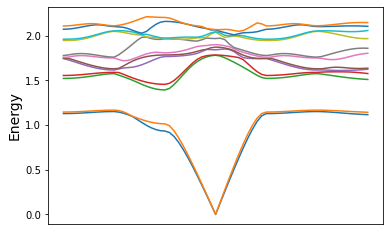

In [72]:
plt.plot(ms.all_freqs * 2*np.pi*3e8/(0.5e-6) * 6.6e-16)
plt.ylabel("Energy", fontsize=14)
plt.xlabel("")
plt.xticks([])

In [20]:
N_offset = 7
vol_FCC = 1
E, omega, vgmag = get_mode_info(ms, mp.Vector3(-0.075, -0.075, -0.075))
Ex = np.array(E[0,0,:,:,:])
Ey = np.array(E[0,1,:,:,:])
Ez = np.array(E[0,2,:,:,:])
Mx = get_M_grid(Ex, material_region_fs, N_offset, vol_FCC)
My = get_M_grid(Ey, material_region_fs, N_offset, vol_FCC)
Mz = get_M_grid(Ez, material_region_fs, N_offset, vol_FCC)

Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
     (1, 1, -1)
Geometric objects:
     block, center = (0,0,0)
          size (1e+20,0.2,0.25)
          axes (0,0,1.41421), (-1.41421,1.41421,0), (1,1,-1)
     block, center = (0.25,0.25,0)
          size (0.2,1e+20,0.25)
          axes (0,0,1.41421), (-1.41421,1.41421,0), (1,1,-1)
Geometric object tree has depth 1 and 12 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<-0.075, -0.075, -0.075>
elapsed time for initialization: 0.05863833427429199
solve_kpoint (-0.075,-0.075,-0.075):
freqs:, k index, k1, k2, k3, kmag/2pi, b

    iteration   36: trace = 3.898654242067904 (0.000862926% change)
    linmin: converged after 2 iterations.
    iteration   37: trace = 3.898632153082163 (0.000566581% change)
    linmin: converged after 2 iterations.
    iteration   38: trace = 3.898618420018921 (0.000352254% change)
    linmin: converged after 2 iterations.
    iteration   39: trace = 3.898608834916884 (0.000245859% change)
    linmin: converged after 2 iterations.
    iteration   40: trace = 3.898601815258738 (0.000180056% change)
    linmin: converged after 2 iterations.
    iteration   41: trace = 3.898597060740022 (0.000121955% change)
    linmin: converged after 2 iterations.
    iteration   42: trace = 3.898593249461939 (9.77603e-05% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 100%)
    iteration   43: trace = 3.898590024313303 (8.2726e-05% change)
    iteration   44: trace = 3.898586898026139 (8.01902e-05% change)
    iteration   45: trac

In [42]:
E_fs, omega_fs, vgmag = get_mode_info(ms_fs, mp.Vector3(-0.1, -0.1, -0.1))
Exf = np.array(E_fs[0,0,:,:,:])
Eyf = np.array(E_fs[0,1,:,:,:])
Ezf = np.array(E_fs[0,2,:,:,:])
Mxf = get_M_grid(Exf, material_region_fs, N_offset, vol_FCC)
Myf = get_M_grid(Eyf, material_region_fs, N_offset, vol_FCC)
Mzf = get_M_grid(Ezf, material_region_fs, N_offset, vol_FCC)
Exf2 = np.array(E_fs[1,0,:,:,:])
Eyf2 = np.array(E_fs[1,1,:,:,:])
Ezf2 = np.array(E_fs[1,2,:,:,:])
Mxf2 = get_M_grid(Exf2, material_region_fs, N_offset, vol_FCC)
Myf2 = get_M_grid(Eyf2, material_region_fs, N_offset, vol_FCC)
Mzf2 = get_M_grid(Ezf2, material_region_fs, N_offset, vol_FCC)

Initializing eigensolver data
Computing 12 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 6 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (0, 0.5, 0.5)
     (0.5, 0, 0.5)
     (0.5, 0.5, 0)
Cell volume = 0.25
Reciprocal lattice vectors (/ 2 pi):
     (-1, 1, 1)
     (1, -1, 1)
     (1, 1, -1)
Geometric objects:
Geometric object tree has depth 1 and 0 object nodes (vs. 0 actual objects)
Initializing epsilon function...
Solving for band polarization: .
Initializing fields to random numbers...
1 k-points
  Vector3<-0.1, -0.1, -0.1>
elapsed time for initialization: 0.027106523513793945
solve_kpoint (-0.1,-0.1,-0.1):
freqs:, k index, k1, k2, k3, kmag/2pi, band 1, band 2, band 3, band 4, band 5, band 6, band 7, band 8, band 9, band 10, band 11, band 12
Solving for bands 1 to 6...
    near maximum in trace
    linmin: converged after 16 iterations.
    iteration    1: trace = 11.28239719763752 (183.406% change)
    

In [12]:
def dot_prod_between(Ex, Ey, Ez, Ex2, Ey2, Ez2):
    pols = np.zeros_like(Ex, dtype=np.float64)
    for i in range(Ex.shape[0]):
        for j in range(Ex.shape[0]):
            for k in range(Ex.shape[0]):
                pols[i, j, k] = np.sum(np.multiply(np.abs([Ex[i, j, k], Ey[i, j, k], Ez[i, j, k]]), np.abs([Ex2[i, j, k], Ey2[i, j, k], Ez2[i, j, k]])))
    return pols

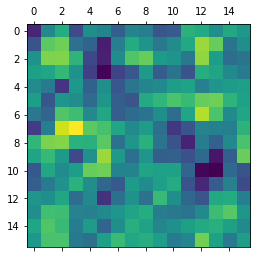

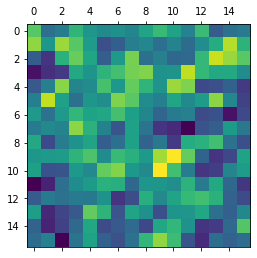

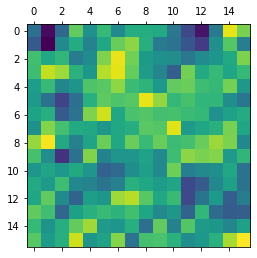

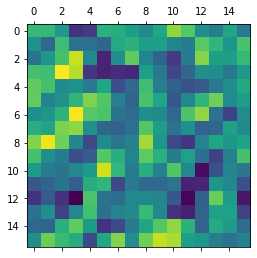

In [13]:
plt.matshow(np.abs(Exf[7]))
plt.matshow(np.abs(Eyf[7]))
plt.matshow(np.abs(Ezf[7]))
plt.matshow(dot_prod_between(Exf, Eyf, Ezf, Exf2, Eyf2, Ezf2)[7])


In [34]:
np.sum(np.multiply([Mxf[3, 3, 3], Myf[3, 3, 3], Mzf[3, 3, 3]], [Mxf2[3, 3, 3], Myf2[3, 3, 3], Mzf2[3, 3, 3]]))

(-3.830288863859721e-11-0.027317355947105194j)

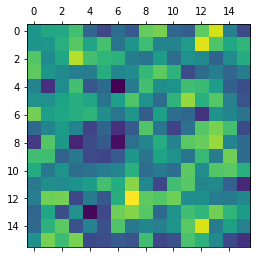

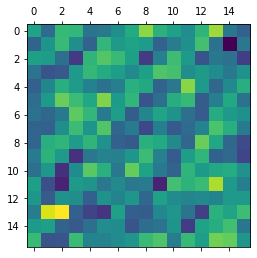

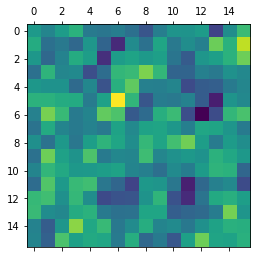

In [34]:
plt.matshow(np.abs(Exf[8]))
plt.matshow(np.abs(Eyf[8]))
plt.matshow(np.abs(Ezf[8]))

0.8225911171631732

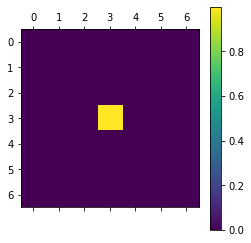

In [49]:
plt.matshow(((np.abs(Mxf[3])**2+ np.abs(Myf[3])**2 + np.abs(Mzf[3])**2)) *4.41*4)
plt.colorbar()
np.sum(np.abs(Mxf**2 + Myf**2 + Mzf**2)*4.41*4)

In [129]:
np.sum(np.abs(Mxf**2 + Mxf2**2)*4.41)

5.26800359566092

1.4759733185550383

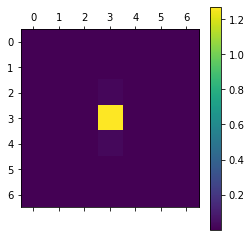

In [28]:
plt.matshow(np.real(Mx[3]**2+ My[3]**2 + Mz[3]**2))
plt.colorbar()
np.sum(np.abs(Mx**2+My**2 + Mz**2))

In [ ]:
plt.pcolormesh(np.abs(eps[7]))
plt.colorbar()

## Diamond lattice

In [ ]:
ms.geometry_lattice = mp.Lattice(basis_size=mp.Vector3(1/np.sqrt(2), 1/np.sqrt(2), 1/np.sqrt(2)),
                                basis1=mp.Vector3(1,0,1),
                                basis2=mp.Vector3(1,1,0),
                                basis3=mp.Vector3(0,1,1))

# in the reciprocal basis, not cartesian
k_points = [
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # U
    mp.Vector3(0.5, 0.5, 0.5),      # L
    mp.Vector3(0, 0, 0),            # Gamma
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # W
    mp.Vector3(0.375, 0.75, 0.375)  # K
]
ms.k_points = mp.interpolate(10, k_points)


ms.geometry = [mp.Sphere(0.325, center=mp.Vector3(0.125, 0.125, 0.125), material=mp.Medium(epsilon=1.0)),
            mp.Sphere(0.325, center=mp.Vector3(-0.125, -0.125, -0.125), material=mp.Medium(epsilon=1.0))]

ms.num_bands = 12
num_bands = 6
ms.default_material=mp.Medium(epsilon=13.0)
ms.run()
eps = np.array(ms.get_epsilon(), dtype=complex)
material_region = get_material_region(eps)

In [ ]:
plt.plot(ms.all_freqs* 2*np.pi*3e8/(0.5e-6)*6.582e-16)
plt.xticks
# np.savez("phc3d_dmnd_bands.npz", ms.all_freqs)

In [ ]:
converter = mpb.MPBData(rectify=True, periods=3, resolution=ms.resolution[0], lattice=ms.get_lattice())
plt.pcolormesh(np.abs(converter.convert(eps)[8]))

In [ ]:
num_sample = 25
BZ_sample = np.linspace(-0.75,0.75, num_sample)
print(BZ_sample)

# number of points in mode integral to keep (which is in Fourier space, remember)
N_offset = 7
vol_FCC = 1/4

Mx_vals = np.zeros([ms.num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
My_vals = np.zeros([ms.num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
Mz_vals = np.zeros([ms.num_bands, num_sample, num_sample, num_sample, N_offset, N_offset, N_offset])
omega_vals = np.zeros([ms.num_bands, num_sample, num_sample, num_sample])
vg_vals = np.zeros([ms.num_bands, num_sample, num_sample, num_sample])
# converter = mpb.MPBData(rectify=True, periods=1, resolution=ms.resolution[0], lattice=ms.get_lattice())


for (l, kx) in enumerate(BZ_sample):
    for (m, ky) in enumerate(BZ_sample):
        for (n, kz) in enumerate(BZ_sample):
            if not (near_1BZ_FCC(FCC_to_cartesian_r @ [kx, ky, kz])):
                continue
            print(time.asctime(time.localtime()))
            print("(l, m, n) = ")
            print("(", str(l), str(m), str(n), ")")
            k = mp.Vector3(kx, ky, kz)
            E, omega, vgmag = get_mode_info(ms, k)
            Mbands = []
            for i in range(num_bands):
                Ex = np.array(E[i,0,:,:,:])
                Ey = np.array(E[i,1,:,:,:])
                Ez = np.array(E[i,2,:,:,:])
                Mx = get_M_grid(Ex, material_region, N_offset, vol_FCC)
                My = get_M_grid(Ey, material_region, N_offset, vol_FCC)
                Mz = get_M_grid(Ez, material_region, N_offset, vol_FCC)
                Mx_vals[i,l,m,n,:,:,:] = Mx
                My_vals[i,l,m,n,:,:,:] = My
                Mz_vals[i,l,m,n,:,:,:] = Mz
            omega_vals[:,l,m,n] = omega
            vg_vals[:,l,m,n] = vgmag

In [ ]:
np.savez("phc3d_iop_e_13_25_4-11-24.npz", BZ_sample, Mx_vals, My_vals, Mz_vals, omega_vals, vg_vals)

 ## Check my theories
- try free space in normal lattice and BCC lattice
- the trick is to see if, after being rectified, they look the same, with perhaps a jacobian factor
### Cubic lattice

In [ ]:
ms.geometry = []
ms.geometry_lattice = mp.Lattice(size=mp.Vector3(1,1,1))
ms.resolution = 32
# rsphere = 0.2
# ms.geometry = [mp.Sphere(rsphere, center=mp.Vector3(0,0,0), material=mp.Medium(epsilon=12.0))]
ms.run()
material_region = np.zeros((ms.resolution[0], ms.resolution[1], ms.resolution[2])) + 1
ms.default_material = mp.Medium(epsilon=1)

In [ ]:
eps = np.array(ms.get_epsilon(), dtype=complex)


In [ ]:
eps.shape

In [ ]:
# number of points in mode integral to keep (which is in Fourier space, remember)
N_offset = 21

k = mp.Vector3(0.1,0,0)
E, omega, vgmag = get_mode_info(ms, k)
Ex1 = np.array(E[0,0,:,:,:])
Ey1 = np.array(E[0,1,:,:,:])
Ez1 = np.array(E[0,2,:,:,:])
Ex2 = np.array(E[1,0,:,:,:])
Ey2 = np.array(E[1,1,:,:,:])
Ez2 = np.array(E[1,2,:,:,:])
Mx1 = get_M_grid(Ex1, material_region, N_offset, 1)
My1 = get_M_grid(Ey1, material_region, N_offset, 1)
Mz1 = get_M_grid(Ez1, material_region, N_offset, 1)
Mx2 = get_M_grid(Ex2, material_region, N_offset, 1)
My2 = get_M_grid(Ey2, material_region, N_offset, 1)
Mz2 = get_M_grid(Ez2, material_region, N_offset, 1)
Mxtot = Mx1**2 + Mx2**2
Mytot = My1**2 + My2**2
Mztot = Mz1**2 + Mz2**2

In [ ]:
print(Mxtot[10,10,10])
print(Mytot[10,10,10])
print(Mztot[10,10,10])


In [ ]:
# BCC
sq3_2 = np.sqrt(3)/2
ms.geometry_lattice = mp.Lattice(basis_size=mp.Vector3(sq3_2,sq3_2,sq3_2),
                                basis1=mp.Vector3(1/2,1/2,-1/2),
                                basis2=mp.Vector3(-1/2,1/2,1/2),
                                basis3=mp.Vector3(1/2,-1/2,1/2))
ms.run()

In [ ]:
# number of points in mode integral to keep (which is in Fourier space, remember)
N_offset = 21

k = mp.Vector3(.1,0,0)
E, omega, vgmag = get_mode_info(ms, k)
Ex1 = np.array(E[0,0,:,:,:])
Ey1 = np.array(E[0,1,:,:,:])
Ez1 = np.array(E[0,2,:,:,:])
Ex2 = np.array(E[1,0,:,:,:])
Ey2 = np.array(E[1,1,:,:,:])
Ez2 = np.array(E[1,2,:,:,:])
Mx1 = get_M_grid(Ex1, material_region, N_offset, 1/2)
My1 = get_M_grid(Ey1, material_region, N_offset, 1/2)
Mz1 = get_M_grid(Ez1, material_region, N_offset, 1/2)
Mx2 = get_M_grid(Ex2, material_region, N_offset, 1/2)
My2 = get_M_grid(Ey2, material_region, N_offset, 1/2)
Mz2 = get_M_grid(Ez2, material_region, N_offset, 1/2)
Mxtot_bcc = Mx1**2 + Mx2**2
Mytot_bcc = My1**2 + My2**2
Mztot_bcc = Mz1**2 + Mz2**2